# Machine Learning in Julia, JuliaCon2020

A workshop introducing the machine learning toolbox
[MLJ](https://alan-turing-institute.github.io/MLJ.jl/stable/).

### Set-up

The following instantiates a package environment and pre-loads some
packages, to avoid delays later on.

The package environment has been created using **Julia 1.6** and may not
instantiate properly for other Julia versions.

In [1]:
VERSION

v"1.6.3"

In [2]:
DIR = @__DIR__
include(joinpath(DIR, "setup.jl"))
color_off()

  Activating environment at `~/Google Drive/Julia/MLJ/MachineLearningInJulia2020/Project.toml`
Precompiling project...
  ✓ InlineStrings
  ✓ WeakRefStrings
  ✓ ScikitLearn
  ✓ CSV
  ✓ MLJScikitLearnInterface
  ✓ CorpusLoaders
  ✓ ScientificTypes
  ✓ OpenML
  ✓ MLJBase
  ✓ MLJEnsembles
  ✓ MLJIteration
  ✓ MLJTuning
  ✓ MLJSerialization
  ✓ MLJModels
  ✓ MLJ
  15 dependencies successfully precompiled in 46 seconds (231 already precompiled)
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1342
┌ Info: Precompiling MLJ [add582a8-e3ab-11e8-2d5e-e98b27df1bc7]
└ @ Base loading.jl:1342
┌ Info: Precompiling MLJScikitLearnInterface [5ae90465-5518-4432-b9d2-8a1def2f0cab]
└ @ Base loading.jl:1342
┌ Info: Done loading
└ @ Main /Users/anthony/Google Drive/Julia/MLJ/MachineLearningInJulia2020/setup.jl:27


false

## General resources

- [List of methods introduced in this tutorial](methods.md)
- [MLJ Cheatsheet](https://alan-turing-institute.github.io/MLJ.jl/dev/mlj_cheatsheet/)
- [Common MLJ Workflows](https://alan-turing-institute.github.io/MLJ.jl/dev/common_mlj_workflows/)
- [MLJ manual](https://alan-turing-institute.github.io/MLJ.jl/dev/)
- [Data Science Tutorials in Julia](https://juliaai.github.io/DataScienceTutorials.jl/)

## Contents

### Basic

- [Part 1 - Data Representation](#part-1-data-representation)
- [Part 2 - Selecting, Training and Evaluating Models](#part-2-selecting-training-and-evaluating-models)
- [Part 3 - Transformers and Pipelines](#part-3-transformers-and-pipelines)
- [Part 4 - Tuning Hyper-parameters](#part-4-tuning-hyper-parameters)
- [Part 5 - Advanced model composition](#part-5-advanced-model-composition)
- [Solutions to Exercises](#solutions-to-exercises)

<a id='part-1-data-representation'></a>

## Part 1 - Data Representation

> **Goals:**
> 1. Learn how MLJ specifies it's data requirements using "scientific" types
> 2. Understand the options for representing tabular data
> 3. Learn how to inspect and fix the representation of data to meet MLJ requirements

### Scientific types

To help you focus on the intended *purpose* or *interpretation* of
data, MLJ models specify data requirements using *scientific types*,
instead of machine types. An example of a scientific type is
`OrderedFactor`. The other basic "scalar" scientific types are
illustrated below:

![](assets/scitypes.png)

A scientific type is an ordinary Julia type (so it can be used for
method dispatch, for example) but it usually has no instances. The
`scitype` function is used to articulate MLJ's convention about how
different machine types will be interpreted by MLJ models:

In [3]:
using MLJ
scitype(3.141)

Continuous

In [4]:
time = [2.3, 4.5, 4.2, 1.8, 7.1]
scitype(time)

AbstractVector{Continuous} (alias for AbstractArray{Continuous, 1})

To fix data which MLJ is interpreting incorrectly, we use the
`coerce` method:

In [5]:
height = [185, 153, 163, 114, 180]
scitype(height)

AbstractVector{Count} (alias for AbstractArray{Count, 1})

In [6]:
height = coerce(height, Continuous)

5-element Vector{Float64}:
 185.0
 153.0
 163.0
 114.0
 180.0

Here's an example of data we would want interpreted as
`OrderedFactor` but isn't:

In [7]:
exam_mark = ["rotten", "great", "bla",  missing, "great"]
scitype(exam_mark)

AbstractVector{Union{Missing, Textual}} (alias for AbstractArray{Union{Missing, Textual}, 1})

In [8]:
exam_mark = coerce(exam_mark, OrderedFactor)

┌ Info: Trying to coerce from `Union{Missing, String}` to `OrderedFactor`.
│ Coerced to `Union{Missing,OrderedFactor}` instead.
└ @ ScientificTypes /Users/anthony/.julia/packages/ScientificTypes/z5Vmr/src/convention/coerce.jl:174


5-element CategoricalArray{Union{Missing, String},1,UInt32}:
 "rotten"
 "great"
 "bla"
 missing
 "great"

In [9]:
levels(exam_mark)

3-element Vector{String}:
 "bla"
 "great"
 "rotten"

Use `levels!` to put the classes in the right order:

In [10]:
levels!(exam_mark, ["rotten", "bla", "great"])
exam_mark[1] < exam_mark[2]

true

When sub-sampling, no levels are lost:

In [11]:
levels(exam_mark[1:2])

3-element Vector{String}:
 "rotten"
 "bla"
 "great"

**Note on binary data.** There is no separate scientific type for
binary data. Binary data is `OrderedFactor{2}` or
`Multiclass{2}`. If a binary measure like `truepositive` is a
applied to `OrderedFactor{2}` then the "positive" class is assumed
to appear *second* in the ordering. If such a measure is applied to
`Multiclass{2}` data, a warning is issued. A single `OrderedFactor`
can be coerced to a single `Continuous` variable, for models that
require this, while a `Multiclass` variable can only be one-hot
encoded.

### Two-dimensional data

Whenever it makes sense, MLJ Models generally expect two-dimensional
data to be *tabular*. All the tabular formats implementing the
[Tables.jl API](https://juliadata.github.io/Tables.jl/stable/) (see
this
[list](https://github.com/JuliaData/Tables.jl/blob/master/INTEGRATIONS.md))
have a scientific type of `Table` and can be used with such models.

Probably the simplest example of a table is the julia native *column
table*, which is just a named tuple of equal-length vectors:

In [12]:
column_table = (h=height, e=exam_mark, t=time)

(h = [185.0, 153.0, 163.0, 114.0, 180.0],
 e = Union{Missing, CategoricalValue{String, UInt32}}["rotten", "great", "bla", missing, "great"],
 t = [2.3, 4.5, 4.2, 1.8, 7.1],)

In [13]:
scitype(column_table)

Table{Union{AbstractVector{Union{Missing, OrderedFactor{3}}}, AbstractVector{Continuous}}}

Notice the `Table{K}` type parameter `K` encodes the scientific
types of the columns. (This is useful when comparing table scitypes
with `<:`). To inspect the individual column scitypes, we use the
`schema` method instead:

In [14]:
schema(column_table)

┌─────────┬──────────────────────────────────────────────────┬──────────────────
│ _.names │ _.types                                          │ _.scitypes      ⋯
├─────────┼──────────────────────────────────────────────────┼──────────────────
│ h       │ Float64                                          │ Continuous      ⋯
│ e       │ Union{Missing, CategoricalValue{String, UInt32}} │ Union{Missing,  ⋯
│ t       │ Float64                                          │ Continuous      ⋯
└─────────┴──────────────────────────────────────────────────┴──────────────────
                                                                1 column omitted
_.nrows = 5


Here are five other examples of tables:

In [15]:
dict_table = Dict(:h => height, :e => exam_mark, :t => time)
schema(dict_table)

┌─────────┬──────────────────────────────────────────────────┬──────────────────
│ _.names │ _.types                                          │ _.scitypes      ⋯
├─────────┼──────────────────────────────────────────────────┼──────────────────
│ e       │ Union{Missing, CategoricalValue{String, UInt32}} │ Union{Missing,  ⋯
│ h       │ Float64                                          │ Continuous      ⋯
│ t       │ Float64                                          │ Continuous      ⋯
└─────────┴──────────────────────────────────────────────────┴──────────────────
                                                                1 column omitted
_.nrows = 5


(To control column order here, instead use `LittleDict` from
OrderedCollections.jl.)

In [16]:
row_table = [(a=1, b=3.4),
             (a=2, b=4.5),
             (a=3, b=5.6)]
schema(row_table)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ a       │ Int64   │ Count      │
│ b       │ Float64 │ Continuous │
└─────────┴─────────┴────────────┘
_.nrows = 3


In [17]:
import DataFrames
df = DataFrames.DataFrame(column_table)

,h,e,t
,Float64,Cat…?,Float64
1,185.0,rotten,2.3
2,153.0,great,4.5
3,163.0,bla,4.2
4,114.0,missing,1.8
5,180.0,great,7.1


In [18]:
schema(df) == schema(column_table)

true

In [19]:
using CSV
file = CSV.File(joinpath(DIR, "data", "horse.csv"));
schema(file) # (triggers a file read)

┌─────────────────────────┬─────────┬────────────┐
│ _.names                 │ _.types │ _.scitypes │
├─────────────────────────┼─────────┼────────────┤
│ surgery                 │ Int64   │ Count      │
│ age                     │ Int64   │ Count      │
│ rectal_temperature      │ Float64 │ Continuous │
│ pulse                   │ Int64   │ Count      │
│ respiratory_rate        │ Int64   │ Count      │
│ temperature_extremities │ Int64   │ Count      │
│ mucous_membranes        │ Int64   │ Count      │
│ capillary_refill_time   │ Int64   │ Count      │
│ pain                    │ Int64   │ Count      │
│ peristalsis             │ Int64   │ Count      │
│ abdominal_distension    │ Int64   │ Count      │
│ packed_cell_volume      │ Float64 │ Continuous │
│ total_protein           │ Float64 │ Continuous │
│ outcome                 │ Int64   │ Count      │
│ surgical_lesion         │ Int64   │ Count      │
│ cp_data                 │ Int64   │ Count      │
└─────────────────────────┴────

Most MLJ models do not accept matrix in lieu of a table, but you can
wrap a matrix as a table:

In [20]:
matrix_table = MLJ.table(rand(2,3))
schema(matrix_table)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ x1      │ Float64 │ Continuous │
│ x2      │ Float64 │ Continuous │
│ x3      │ Float64 │ Continuous │
└─────────┴─────────┴────────────┘
_.nrows = 2


The matrix is *not* copied, only wrapped. Some models may perform
better if one wraps the adjoint of the transpose - see
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#Observations-correspond-to-rows,-not-columns).

**Manipulating tabular data.** In this workshop we assume
familiarity with some kind of tabular data container (although it is
possible, in principle, to carry out the exercises without this.)
For a quick start introduction to `DataFrames`, see [this
tutorial](https://juliaai.github.io/DataScienceTutorials.jl/data/dataframe/).

### Fixing scientific types in tabular data

To show how we can correct the scientific types of data in tables,
we introduce a cleaned up version of the UCI Horse Colic Data Set
(the cleaning work-flow is described
[here](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/horse/#dealing_with_missing_values)).

In [21]:
using CSV
file = CSV.File(joinpath(DIR, "data", "horse.csv"));
horse = DataFrames.DataFrame(file); # convert to data frame without copying columns
first(horse, 4)

,surgery,age,rectal_temperature,pulse,respiratory_rate,temperature_extremities
,Int64,Int64,Float64,Int64,Int64,Int64
1,2,1,38.5,66,66,3
2,1,1,39.2,88,88,3
3,2,1,38.3,40,40,1
4,1,9,39.1,164,164,4


From [the UCI
docs](http://archive.ics.uci.edu/ml/datasets/Horse+Colic) we can
surmise how each variable ought to be interpreted (a step in our
work-flow that cannot reliably be left to the computer):

variable                    | scientific type (interpretation)
----------------------------|-----------------------------------
`:surgery`                  | Multiclass
`:age`                      | Multiclass
`:rectal_temperature`       | Continuous
`:pulse`                    | Continuous
`:respiratory_rate`         | Continuous
`:temperature_extremities`  | OrderedFactor
`:mucous_membranes`         | Multiclass
`:capillary_refill_time`    | Multiclass
`:pain`                     | OrderedFactor
`:peristalsis`              | OrderedFactor
`:abdominal_distension`     | OrderedFactor
`:packed_cell_volume`       | Continuous
`:total_protein`            | Continuous
`:outcome`                  | Multiclass
`:surgical_lesion`          | OrderedFactor
`:cp_data`                  | Multiclass

Let's see how MLJ will actually interpret the data, as it is
currently encoded:

In [22]:
schema(horse)

┌─────────────────────────┬─────────┬────────────┐
│ _.names                 │ _.types │ _.scitypes │
├─────────────────────────┼─────────┼────────────┤
│ surgery                 │ Int64   │ Count      │
│ age                     │ Int64   │ Count      │
│ rectal_temperature      │ Float64 │ Continuous │
│ pulse                   │ Int64   │ Count      │
│ respiratory_rate        │ Int64   │ Count      │
│ temperature_extremities │ Int64   │ Count      │
│ mucous_membranes        │ Int64   │ Count      │
│ capillary_refill_time   │ Int64   │ Count      │
│ pain                    │ Int64   │ Count      │
│ peristalsis             │ Int64   │ Count      │
│ abdominal_distension    │ Int64   │ Count      │
│ packed_cell_volume      │ Float64 │ Continuous │
│ total_protein           │ Float64 │ Continuous │
│ outcome                 │ Int64   │ Count      │
│ surgical_lesion         │ Int64   │ Count      │
│ cp_data                 │ Int64   │ Count      │
└─────────────────────────┴────

As a first correction step, we can get MLJ to "guess" the
appropriate fix, using the `autotype` method:

In [23]:
autotype(horse)

Dict{Symbol, Type} with 11 entries:
  :abdominal_distension    => OrderedFactor
  :pain                    => OrderedFactor
  :surgery                 => OrderedFactor
  :mucous_membranes        => OrderedFactor
  :surgical_lesion         => OrderedFactor
  :outcome                 => OrderedFactor
  :capillary_refill_time   => OrderedFactor
  :age                     => OrderedFactor
  :temperature_extremities => OrderedFactor
  :peristalsis             => OrderedFactor
  :cp_data                 => OrderedFactor

Okay, this is not perfect, but a step in the right direction, which
we implement like this:

In [24]:
coerce!(horse, autotype(horse));
schema(horse)

┌─────────────────────────┬─────────────────────────────────┬───────────────────
│ _.names                 │ _.types                         │ _.scitypes       ⋯
├─────────────────────────┼─────────────────────────────────┼───────────────────
│ surgery                 │ CategoricalValue{Int64, UInt32} │ OrderedFactor{2} ⋯
│ age                     │ CategoricalValue{Int64, UInt32} │ OrderedFactor{2} ⋯
│ rectal_temperature      │ Float64                         │ Continuous       ⋯
│ pulse                   │ Int64                           │ Count            ⋯
│ respiratory_rate        │ Int64                           │ Count            ⋯
│ temperature_extremities │ CategoricalValue{Int64, UInt32} │ OrderedFactor{4} ⋯
│ mucous_membranes        │ CategoricalValue{Int64, UInt32} │ OrderedFactor{6} ⋯
│ capillary_refill_time   │ CategoricalValue{Int64, UInt32} │ OrderedFactor{3} ⋯
│ pain                    │ CategoricalValue{Int64, UInt32} │ OrderedFactor{5} ⋯
│ peristalsis             │ 

All remaining `Count` data should be `Continuous`:

In [25]:
coerce!(horse, Count => Continuous);
schema(horse)

┌─────────────────────────┬─────────────────────────────────┬───────────────────
│ _.names                 │ _.types                         │ _.scitypes       ⋯
├─────────────────────────┼─────────────────────────────────┼───────────────────
│ surgery                 │ CategoricalValue{Int64, UInt32} │ OrderedFactor{2} ⋯
│ age                     │ CategoricalValue{Int64, UInt32} │ OrderedFactor{2} ⋯
│ rectal_temperature      │ Float64                         │ Continuous       ⋯
│ pulse                   │ Float64                         │ Continuous       ⋯
│ respiratory_rate        │ Float64                         │ Continuous       ⋯
│ temperature_extremities │ CategoricalValue{Int64, UInt32} │ OrderedFactor{4} ⋯
│ mucous_membranes        │ CategoricalValue{Int64, UInt32} │ OrderedFactor{6} ⋯
│ capillary_refill_time   │ CategoricalValue{Int64, UInt32} │ OrderedFactor{3} ⋯
│ pain                    │ CategoricalValue{Int64, UInt32} │ OrderedFactor{5} ⋯
│ peristalsis             │ 

We'll correct the remaining truant entries manually:

In [26]:
coerce!(horse,
        :surgery               => Multiclass,
        :age                   => Multiclass,
        :mucous_membranes      => Multiclass,
        :capillary_refill_time => Multiclass,
        :outcome               => Multiclass,
        :cp_data               => Multiclass);
schema(horse)

┌─────────────────────────┬─────────────────────────────────┬───────────────────
│ _.names                 │ _.types                         │ _.scitypes       ⋯
├─────────────────────────┼─────────────────────────────────┼───────────────────
│ surgery                 │ CategoricalValue{Int64, UInt32} │ Multiclass{2}    ⋯
│ age                     │ CategoricalValue{Int64, UInt32} │ Multiclass{2}    ⋯
│ rectal_temperature      │ Float64                         │ Continuous       ⋯
│ pulse                   │ Float64                         │ Continuous       ⋯
│ respiratory_rate        │ Float64                         │ Continuous       ⋯
│ temperature_extremities │ CategoricalValue{Int64, UInt32} │ OrderedFactor{4} ⋯
│ mucous_membranes        │ CategoricalValue{Int64, UInt32} │ Multiclass{6}    ⋯
│ capillary_refill_time   │ CategoricalValue{Int64, UInt32} │ Multiclass{3}    ⋯
│ pain                    │ CategoricalValue{Int64, UInt32} │ OrderedFactor{5} ⋯
│ peristalsis             │ 

### Resources for Part 1

- From the MLJ manual:
   - [A preview of data type specification in
  MLJ](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#A-preview-of-data-type-specification-in-MLJ-1)
   - [Data containers and scientific types](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#Data-containers-and-scientific-types-1)
   - [Working with Categorical Data](https://alan-turing-institute.github.io/MLJ.jl/dev/working_with_categorical_data/)
- [Summary](https://juliaai.github.io/ScientificTypes.jl/dev/#Summary-of-the-default-convention) of the MLJ convention for representing scientific types
- [ScientificTypes.jl](https://juliaai.github.io/ScientificTypes.jl/dev/)
- From Data Science Tutorials:
    - [Data interpretation: Scientific Types](https://juliaai.github.io/DataScienceTutorials.jl/data/scitype/)
    - [Horse colic data](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/horse/)
- [UCI Horse Colic Data Set](http://archive.ics.uci.edu/ml/datasets/Horse+Colic)

### Exercises for Part 1

#### Exercise 1

Try to guess how each code snippet below will evaluate:

In [27]:
scitype(42)

Count

In [28]:
questions = ["who", "why", "what", "when"]
scitype(questions)

AbstractVector{Textual} (alias for AbstractArray{Textual, 1})

In [29]:
elscitype(questions)

Textual

In [30]:
t = (3.141, 42, "how")
scitype(t)

Tuple{Continuous, Count, Textual}

In [31]:
A = rand(2, 3)

2×3 Matrix{Float64}:
 0.578566  0.0280166  0.974146
 0.518531  0.910351   0.796979

-

In [32]:
scitype(A)

AbstractMatrix{Continuous} (alias for AbstractArray{Continuous, 2})

In [33]:
elscitype(A)

Continuous

In [34]:
using SparseArrays
Asparse = sparse(A)

2×3 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 0.578566  0.0280166  0.974146
 0.518531  0.910351   0.796979

In [35]:
scitype(Asparse)

AbstractMatrix{Continuous} (alias for AbstractArray{Continuous, 2})

In [36]:
using CategoricalArrays
C1 = categorical(A)

2×3 CategoricalArray{Float64,2,UInt32}:
 0.578566  0.0280166  0.974146
 0.518531  0.910351   0.796979

In [37]:
scitype(C1)

AbstractMatrix{Multiclass{6}} (alias for AbstractArray{Multiclass{6}, 2})

In [38]:
elscitype(C1)

Multiclass{6}

In [39]:
C2 = categorical(A, ordered=true)
scitype(C2)

AbstractMatrix{OrderedFactor{6}} (alias for AbstractArray{OrderedFactor{6}, 2})

In [40]:
v = [1, 2, missing, 4]
scitype(v)

AbstractVector{Union{Missing, Count}} (alias for AbstractArray{Union{Missing, Count}, 1})

In [41]:
elscitype(v)

Union{Missing, Count}

In [42]:
scitype(v[1:2])

AbstractVector{Union{Missing, Count}} (alias for AbstractArray{Union{Missing, Count}, 1})

Can you guess at the general behavior of
`scitype` with respect to tuples, abstract arrays and missing
values? The answers are
[here](https://github.com/juliaai/ScientificTypesBase.jl#2-the-scitype-and-scitype-methods)
(ignore "Property 1").

#### Exercise 2

Coerce the following vector to make MLJ recognize it as a vector of
ordered factors (with an appropriate ordering):

In [43]:
quality = ["good", "poor", "poor", "excellent", missing, "good", "excellent"]

7-element Vector{Union{Missing, String}}:
 "good"
 "poor"
 "poor"
 "excellent"
 missing
 "good"
 "excellent"

#### Exercise 3 (fixing scitypes in a table)

Fix the scitypes for the [House Prices in King
County](https://mlr3gallery.mlr-org.com/posts/2020-01-30-house-prices-in-king-county/)
dataset:

In [44]:
file = CSV.File(joinpath(DIR, "data", "house.csv"));
house = DataFrames.DataFrame(file); # convert to data frame without copying columns
first(house, 4)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view
,Float64,Int64,Float64,Int64,Int64,Float64,Int64,Int64
1,221900.0,3,1.0,1180,5650,1.0,0,0
2,538000.0,3,2.25,2570,7242,2.0,0,0
3,180000.0,2,1.0,770,10000,1.0,0,0
4,604000.0,4,3.0,1960,5000,1.0,0,0


(Two features in the original data set have been deemed uninformative
and dropped, namely `:id` and `:date`. The original feature
`:yr_renovated` has been replaced by the `Bool` feature `is_renovated`.)

<a id='part-2-selecting-training-and-evaluating-models'></a>

## Part 2 - Selecting, Training and Evaluating Models

> **Goals:**
> 1. Search MLJ's database of model metadata to identify model candidates for a supervised learning task.
> 2. Evaluate the performance of a model on a holdout set using basic `fit!`/`predict` work-flow.
> 3. Inspect the outcomes of training and save these to a file.
> 3. Evaluate performance using other resampling strategies, such as cross-validation, in one line, using `evaluate!`
> 4. Plot a "learning curve", to inspect performance as a function of some model hyper-parameter, such as an iteration parameter

The "Hello World!" of machine learning is to classify Fisher's
famous iris data set. This time, we'll grab the data from
[OpenML](https://www.openml.org):

In [45]:
OpenML.describe_dataset(61)

**Author**: R.A. Fisher   **Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Iris) - 1936 - Donated by Michael Marshall   **Please cite**:   

**Iris Plants Database**   This is perhaps the best known database to be found in the pattern recognition literature.  Fisher's paper is a classic in the field and is referenced frequently to this day.  (See Duda & Hart, for example.)  The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One class is     linearly separable from the other 2; the latter are NOT linearly separable from each other.

Predicted attribute: class of iris plant.   This is an exceedingly simple domain.  

### Attribute Information:

```
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class: 
   -- Iris Setosa
   -- Iris Versicolour
   -- Iris Virginica
```


In [46]:
iris = OpenML.load(61); # a row table
iris = DataFrames.DataFrame(iris);
first(iris, 4)

,sepallength,sepalwidth,petallength,petalwidth,class
,Float64?,Float64?,Float64?,Float64?,Cat…?
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa


**Main goal.** To build and evaluate models for predicting the
`:class` variable, given the four remaining measurement variables.

### Step 1. Inspect and fix scientific types

In [47]:
schema(iris)

┌─────────────┬──────────────────────────────────────────────────┬──────────────
│ _.names     │ _.types                                          │ _.scitypes  ⋯
├─────────────┼──────────────────────────────────────────────────┼──────────────
│ sepallength │ Union{Missing, Float64}                          │ Union{Missi ⋯
│ sepalwidth  │ Union{Missing, Float64}                          │ Union{Missi ⋯
│ petallength │ Union{Missing, Float64}                          │ Union{Missi ⋯
│ petalwidth  │ Union{Missing, Float64}                          │ Union{Missi ⋯
│ class       │ Union{Missing, CategoricalValue{String, UInt32}} │ Union{Missi ⋯
└─────────────┴──────────────────────────────────────────────────┴──────────────
                                                                1 column omitted
_.nrows = 150


Unfortunately, `Missing` is appearing in the element type, despite
the fact there are no missing values (see this
[issue](https://github.com/JuliaAI/OpenML.jl/issues/10)). To do this
we have to explicilty tighten the types:

In [48]:
coerce!(iris,
        Union{Missing,Continuous}=>Continuous,
        Union{Missing,Multiclass}=>Multiclass,
        tight=true)
schema(iris)

┌─────────────┬──────────────────────────────────┬───────────────┐
│ _.names     │ _.types                          │ _.scitypes    │
├─────────────┼──────────────────────────────────┼───────────────┤
│ sepallength │ Float64                          │ Continuous    │
│ sepalwidth  │ Float64                          │ Continuous    │
│ petallength │ Float64                          │ Continuous    │
│ petalwidth  │ Float64                          │ Continuous    │
│ class       │ CategoricalValue{String, UInt32} │ Multiclass{3} │
└─────────────┴──────────────────────────────────┴───────────────┘
_.nrows = 150


### Step 2. Split data into input and target parts

Here's how we split the data into target and input features, which
is needed for MLJ supervised models. We randomize the data at the
same time:

In [49]:
y, X = unpack(iris, ==(:class), name->true; rng=123);
scitype(y)

AbstractVector{Multiclass{3}} (alias for AbstractArray{Multiclass{3}, 1})

Here's one way to access the documentation (at the REPL, `?unpack`
also works):

In [50]:
@doc unpack

```
t1, t2, ...., tk = unpack(table, f1, f2, ... fk;
                         wrap_singles=false,
                         shuffle=false,
                         rng::Union{AbstractRNG,Int,Nothing}=nothing)
```

Horizontally split any Tables.jl compatible `table` into smaller tables (or vectors) `t1, t2, ..., tk` by making column selections **without replacement** by successively applying the columnn name filters `f1`, `f2`, ..., `fk`. A *filter* is any object `f` such that `f(name)` is `true` or `false` for each column `name::Symbol` of `table`. For example, use the filter `_ -> true` to pick up all remaining columns of the table.

Whenever a returned table contains a single column, it is converted to a vector unless `wrap_singles=true`.

Scientific type conversions can be optionally specified (note semicolon):

```
unpack(table, t...; col1=>scitype1, col2=>scitype2, ... )
```

If `shuffle=true` then the rows of `table` are first shuffled, using the global RNG, unless `rng` is specified; if `rng` is an integer, it specifies the seed of an automatically generated Mersenne twister. If `rng` is specified then `shuffle=true` is implicit.

### Example

```
julia> table = DataFrame(x=[1,2], y=['a', 'b'], z=[10.0, 20.0], w=["A", "B"])
julia> Z, XY = unpack(table, ==(:z), !=(:w);
               :x=>Continuous, :y=>Multiclass)
julia> XY
2×2 DataFrame
│ Row │ x       │ y            │
│     │ Float64 │ Categorical… │
├─────┼─────────┼──────────────┤
│ 1   │ 1.0     │ 'a'          │
│ 2   │ 2.0     │ 'b'          │

julia> Z
2-element Array{Float64,1}:
 10.0
 20.0
```


### On searching for a model

Here's how to see *all* models (not immediately useful):

In [51]:
all_models = models()

183-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = ABODDetector, package_name = OutlierDetectionNeighbors, ... )
 (name = ABODDetector, package_name = OutlierDetectionPython, ... )
 (name = AEDetector, package_name = OutlierDetectionNetworks, ... )
 (name = ARDRegressor, package_name = ScikitLearn, ... )
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostRegressor, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, pa

Each entry contains metadata for a model whose defining code is not yet loaded:

In [52]:
meta = all_models[3]

AEDetector from OutlierDetectionNetworks.jl.
[Documentation](https://github.com/OutlierDetectionJL/OutlierDetectionNetworks.jl).
(name = "AEDetector",
 package_name = "OutlierDetectionNetworks",
 is_supervised = false,
 abstract_type = MLJModelInterface.UnsupervisedDetector,
 deep_properties = (),
 docstring = "AEDetector from OutlierDetectionNetworks.jl.\n[Documentation](https://github.com/OutlierDetectionJL/OutlierDetectionNetworks.jl).",
 fit_data_scitype = Tuple{Union{Table{_s52} where _s52<:(AbstractVector{_s51} where _s51<:Continuous), AbstractMatrix{_s689} where _s689<:Continuous}},
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Flux.Chain", "Flux.Chain", "Integer", "Integer", "Bool", "Bool", "Any", "Function"),
 hyperparameters = (:encoder, :decoder, :batchsize, :epochs, :shuffle, :partial, :opt, :loss),
 implemented_methods = [:clean!, :fit, :transform],
 inverse_transform_scitype = Unknown,
 is_pure

In [53]:
targetscitype = meta.target_scitype

AbstractVector{_s689} where _s689<:Union{Missing, OrderedFactor{2}} (alias for AbstractArray{_s689, 1} where _s689<:Union{Missing, OrderedFactor{2}})

In [54]:
scitype(y) <: targetscitype

false

So this model won't do. Let's  find all pure julia classifiers:

In [55]:
filter_julia_classifiers(meta) =
    AbstractVector{Finite} <: meta.target_scitype &&
    meta.is_pure_julia

models(filter_julia_classifiers)

21-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = BetaML, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClas

Find all models with "Classifier" in `name` (or `docstring`):

In [56]:
models("Classifier")

45-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BernoulliNBClassifier, package_name = ScikitLearn, ... )
 (name = ComplementNBClassifier, package_name = ScikitLearn, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, packa

Find all (supervised) models that match my data!

In [57]:
models(matching(X, y))

47-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateS

### Step 3. Select and instantiate a model

To load the code defining a new model type we use the `@load` macro:

In [58]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


import MLJFlux ✔


MLJFlux.NeuralNetworkClassifier

Other ways to load model code are described
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/loading_model_code/#Loading-Model-Code).

We'll instantiate this type with default values for the
hyperparameters:

In [59]:
model = NeuralNetworkClassifier()

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    rng = Random._GLOBAL_RNG(),
    optimiser_changes_trigger_retraining = false,
    acceleration = CPU1{Nothing}(nothing))

In [60]:
info(model)

A neural network model for making probabilistic predictions of a `Multiclass` or `OrderedFactor` target, given a table of `Continuous` features. 
→ based on [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl).
→ do `@load NeuralNetworkClassifier pkg="MLJFlux"` to use the model.
→ do `?NeuralNetworkClassifier` for documentation.
(name = "NeuralNetworkClassifier",
 package_name = "MLJFlux",
 is_supervised = true,
 abstract_type = Probabilistic,
 deep_properties = (:optimiser, :builder),
 docstring = "A neural network model for making probabilistic predictions of a `Multiclass` or `OrderedFactor` target, given a table of `Continuous` features. \n→ based on [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl).\n→ do `@load NeuralNetworkClassifier pkg=\"MLJFlux\"` to use the model.\n→ do `?NeuralNetworkClassifier` for documentation.",
 fit_data_scitype = Tuple{Table{var"#s53"} where var"#s53"<:(AbstractVector{var"#s52"} where var"#s52"<:Continuous), AbstractVector{var"#

In MLJ a *model* is just a struct containing hyper-parameters, and
that's all. A model does not store *learned* parameters. Models are
mutable:

In [61]:
model.epochs = 12

12

And all models have a key-word constructor that works once `@load`
has been performed:

In [62]:
NeuralNetworkClassifier(epochs=12) == model

true

### On fitting, predicting, and inspecting models

In MLJ a model and training/validation data are typically bound
together in a machine:

In [63]:
mach = machine(model, X, y)

Machine{NeuralNetworkClassifier{Short,…},…} trained 0 times; caches data
  args: 
    1:	Source @429 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @444 ⏎ `AbstractVector{Multiclass{3}}`


A machine stores *learned* parameters, among other things. We'll
train this machine on 70% of the data and evaluate on a 30% holdout
set. Let's start by dividing all row indices into `train` and `test`
subsets:

In [64]:
train, test = partition(eachindex(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  96, 97, 98, 99, 100, 101, 102, 103, 104, 105], [106, 107, 108, 109, 110, 111, 112, 113, 114, 115  …  141, 142, 143, 144, 145, 146, 147, 148, 149, 150])

Now we can `fit!`...

In [65]:
fit!(mach, rows=train, verbosity=2)

┌ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Loss is 1.132
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.08
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.068
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.033
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.029
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.9917
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.01
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.005
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 1.003
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info:

Machine{NeuralNetworkClassifier{Short,…},…} trained 1 time; caches data
  args: 
    1:	Source @429 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @444 ⏎ `AbstractVector{Multiclass{3}}`


... and `predict`:

In [66]:
yhat = predict(mach, rows=test);  # or `predict(mach, Xnew)`
yhat[1:3]

3-element MLJBase.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.277, Iris-versicolor=>0.366, Iris-virginica=>0.357)
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.251, Iris-versicolor=>0.376, Iris-virginica=>0.373)
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.494, Iris-versicolor=>0.278, Iris-virginica=>0.227)

We'll have more to say on the form of this prediction shortly.

After training, one can inspect the learned parameters:

In [67]:
fitted_params(mach)

(chain = Chain(Chain(Dense(4, 3, σ), Dropout(0.5), Dense(3, 3)), softmax),)

Everything else the user might be interested in is accessed from the
training *report*:

In [68]:
report(mach)

(training_losses = [1.085632308348892, 1.1320773531582096, 1.0799144410260113, 1.0684055699601498, 1.0326802305670144, 1.0286735172997612, 0.9916782091001018, 1.0103330144134601, 1.0052723608475305, 1.0032265584476034, 0.9890359632792628, 0.9486166278543674, 0.9570811840979994],)

You save a machine like this:

In [69]:
MLJ.save("neural_net.jlso", mach)

And retrieve it like this:

In [70]:
mach2 = machine("neural_net.jlso")
yhat = predict(mach2, X);
yhat[1:3]

3-element MLJBase.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.223, Iris-versicolor=>0.377, Iris-virginica=>0.4)
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.283, Iris-versicolor=>0.366, Iris-virginica=>0.351)
 UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.245, Iris-versicolor=>0.38, Iris-virginica=>0.374)

If you want to fit a retrieved model, you will need to bind some data to it:

In [71]:
mach3 = machine("neural_net.jlso", X, y)
fit!(mach3)

┌ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
Optimising neural net:100%[=========================] Time: 0:00:00


Machine{NeuralNetworkClassifier{Short,…},…} trained 2 times; caches data
  args: 
    1:	Source @960 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @704 ⏎ `AbstractVector{Multiclass{3}}`


Machines remember the last set of hyper-parameters used during fit,
which, in the case of iterative models, allows for a warm restart of
computations in the case that only the iteration parameter is
increased:

In [72]:
model.epochs = model.epochs + 4
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:404
┌ Info: Loss is 0.8915
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.8667
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.8937
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.9132
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128


Machine{NeuralNetworkClassifier{Short,…},…} trained 2 times; caches data
  args: 
    1:	Source @429 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @444 ⏎ `AbstractVector{Multiclass{3}}`


For this particular model we can also increase `:learning_rate`
without triggering a cold restart:

In [73]:
model.epochs = model.epochs + 4
model.optimiser.eta = 10*model.optimiser.eta
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:404
┌ Info: Loss is 0.7963
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.7339
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.7615
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.6521
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128


Machine{NeuralNetworkClassifier{Short,…},…} trained 3 times; caches data
  args: 
    1:	Source @429 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @444 ⏎ `AbstractVector{Multiclass{3}}`


However, change any other parameter and training will restart from
scratch:

In [74]:
model.lambda = 0.001
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:404
┌ Info: Loss is 1.189
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.9707
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.9315
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.8361
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.8291
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.7744
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.817
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.7495
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128
┌ Info: Loss is 0.8286
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/5ENQA/src/core.jl:128

Machine{NeuralNetworkClassifier{Short,…},…} trained 4 times; caches data
  args: 
    1:	Source @429 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @444 ⏎ `AbstractVector{Multiclass{3}}`


Iterative models that implement warm-restart for training can be
controlled externally (eg, using an out-of-sample stopping
criterion). See
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/controlling_iterative_models/)
for details.

Let's train silently for a total of 50 epochs, and look at a
prediction:

In [75]:
model.epochs = 50
fit!(mach, rows=train)
yhat = predict(mach, X[test,:]); # or predict(mach, rows=test)
yhat[1]

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:404
Optimising neural net:100%[=========================] Time: 0:00:01


UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.0815, Iris-versicolor=>0.491, Iris-virginica=>0.428)

What's going on here?

In [76]:
info(model).prediction_type

:probabilistic

**Important**:
- In MLJ, a model that can predict probabilities (and not just point values) will do so by default.
- For most probabilistic predictors, the predicted object is a `Distributions.Distribution` object, supporting the `Distributions.jl` [API](https://juliastats.org/Distributions.jl/latest/extends/#Create-a-Distribution-1) for such objects. In particular, the methods `rand`,  `pdf`, `logpdf`, `mode`, `median` and `mean` will apply, where appropriate.

So, to obtain the probability of "Iris-virginica" in the first test
prediction, we do

In [77]:
pdf(yhat[1], "Iris-virginica")

0.4278096647438517

To get the most likely observation, we do

In [78]:
mode(yhat[1])

CategoricalValue{String, UInt32} "Iris-versicolor"

These can be broadcast over multiple predictions in the usual way:

In [79]:
broadcast(pdf, yhat[1:4], "Iris-versicolor")

4-element Vector{Float64}:
 0.4906890545157449
 0.4263386756761465
 0.03496101759113145
 0.40529054408497234

In [80]:
mode.(yhat[1:4])

4-element CategoricalArray{String,1,UInt32}:
 "Iris-versicolor"
 "Iris-virginica"
 "Iris-setosa"
 "Iris-virginica"

Or, alternatively, you can use the `predict_mode` operation instead
of `predict`:

In [81]:
predict_mode(mach, X[test,:])[1:4] # or predict_mode(mach, rows=test)[1:4]

4-element CategoricalArray{String,1,UInt32}:
 "Iris-versicolor"
 "Iris-virginica"
 "Iris-setosa"
 "Iris-virginica"

For a more conventional matrix of probabilities you can do this:

In [82]:
L = levels(y)
pdf(yhat, L)[1:4, :]

4×3 Matrix{Float64}:
 0.0815013  0.490689  0.42781
 0.0565988  0.426339  0.517062
 0.965022   0.034961  1.68514e-5
 0.050214   0.405291  0.544495

However, in a typical MLJ work-flow, this is not as useful as you
might imagine. In particular, all probabilistic performance measures
in MLJ expect distribution objects in their first slot:

In [83]:
cross_entropy(yhat, y[test]) |> mean

0.46064123289626785

To apply a deterministic measure, we first need to obtain point-estimates:

In [84]:
misclassification_rate(mode.(yhat), y[test])

0.15555555555555556

We note in passing that there is also a search tool for measures
analogous to `models`:

In [85]:
measures()

61-element Vector{NamedTuple{(:name, :instances, :human_name, :target_scitype, :supports_weights, :supports_class_weights, :prediction_type, :orientation, :reports_each_observation, :aggregation, :is_feature_dependent, :docstring, :distribution_type), T} where T<:Tuple}:
 (name = BrierLoss, instances = [brier_loss], ...)
 (name = BrierScore, instances = [brier_score], ...)
 (name = LPLoss, instances = [l1, l2], ...)
 (name = LogCoshLoss, instances = [log_cosh, log_cosh_loss], ...)
 (name = LogLoss, instances = [log_loss, cross_entropy], ...)
 (name = LogScore, instances = [log_score], ...)
 (name = SphericalScore, instances = [spherical_score], ...)
 (name = Accuracy, instances = [accuracy], ...)
 (name = AreaUnderCurve, instances = [area_under_curve, auc], ...)
 (name = BalancedAccuracy, instances = [balanced_accuracy, bacc, bac], ...)
 (name = ConfusionMatrix, instances = [confusion_matrix, confmat], ...)
 (name = FScore, instances = [f1score], ...)
 (name = FalseDiscoveryRate, insta

### Step 4. Evaluate the model performance

Naturally, MLJ provides boilerplate code for carrying out a model
evaluation with a lot less fuss. Let's repeat the performance
evaluation above and add an extra measure, `brier_score`:

In [86]:
evaluate!(mach, resampling=Holdout(fraction_train=0.7),
          measures=[cross_entropy, brier_score])

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬──────────┐
│ measure                    │ measurement │ operation │ per_fold │
├────────────────────────────┼─────────────┼───────────┼──────────┤
│ LogLoss(tol = 2.22045e-16) │ 0.461       │ predict   │ [0.461]  │
│ BrierScore()               │ -0.286      │ predict   │ [-0.286] │
└────────────────────────────┴─────────────┴───────────┴──────────┘


Or applying cross-validation instead:

In [87]:
evaluate!(mach, resampling=CV(nfolds=6),
          measures=[cross_entropy, brier_score])

Evaluating over 6 folds: 100%[=========================] Time: 0:00:24


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────
│ measure                    │ measurement │ operation │ per_fold              ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.381       │ predict   │ [0.4, 0.342, 0.399, 0 ⋯
│ BrierScore()               │ -0.206      │ predict   │ [-0.222, -0.181, -0.2 ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────
                                                                1 column omitted


Or, Monte Carlo cross-validation (cross-validation repeated
randomized folds)

In [88]:
e = evaluate!(mach, resampling=CV(nfolds=6, rng=123),
              repeats=3,
              measures=[cross_entropy, brier_score])

Evaluating over 18 folds: 100%[=========================] Time: 0:01:17


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────
│ measure                    │ measurement │ operation │ per_fold              ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.399       │ predict   │ [0.285, 0.346, 0.384, ⋯
│ BrierScore()               │ -0.222      │ predict   │ [-0.162, -0.181, -0.2 ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────
                                                                1 column omitted


One can access the following properties of the output `e` of an
evaluation: `measure`, `measurement`, `per_fold` (measurement for
each fold) and `per_observation` (measurement per observation, if
reported).

We finally note that you can restrict the rows of observations from
which train and test folds are drawn, by specifying `rows=...`. For
example, imagining the last 30% of target observations are `missing`
you might have a work-flow like this:

In [89]:
train, test = partition(eachindex(y), 0.7)
mach = machine(model, X, y)
evaluate!(mach, resampling=CV(nfolds=6),
          measures=[cross_entropy, brier_score],
          rows=train)     # cv estimate, resampling from `train`
fit!(mach, rows=train)    # re-train using all of `train` observations
predict(mach, rows=test); # and predict missing targets

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/resampling.jl:495
Evaluating over 6 folds: 100%[=========================] Time: 0:00:19
┌ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
Optimising neural net:100%[=========================] Time: 0:00:03


### On learning curves

Since our model is an iterative one, we might want to inspect the
out-of-sample performance as a function of the iteration
parameter. For this we can use the `learning_curve` function (which,
incidentally can be applied to any model hyper-parameter). This
starts by defining a one-dimensional range object for the parameter
(more on this when we discuss tuning in Part 4):

In [90]:
r = range(model, :epochs, lower=1, upper=50, scale=:log)

NumericRange(1 ≤ epochs ≤ 50; origin=25.5, unit=24.5) on log scale

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 22 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 22 metamodels: 100%[=========================] Time: 0:00:06


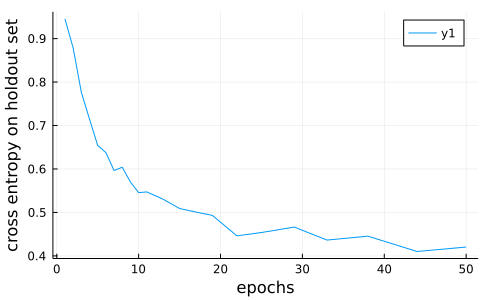

In [91]:
curve = learning_curve(mach,
                       range=r,
                       resampling=Holdout(fraction_train=0.7), # (default)
                       measure=cross_entropy)

using Plots
gr(size=(490,300))
plt=plot(curve.parameter_values, curve.measurements)
xlabel!(plt, "epochs")
ylabel!(plt, "cross entropy on holdout set")
savefig("learning_curve.png")
plt

We will return to learning curves when we look at tuning in Part 4.

### Resources for Part 2

- From the MLJ manual:
    - [Getting Started](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/)
    - [Model Search](https://alan-turing-institute.github.io/MLJ.jl/dev/model_search/)
    - [Evaluating Performance](https://alan-turing-institute.github.io/MLJ.jl/dev/evaluating_model_performance/) (using `evaluate!`)
    - [Learning Curves](https://alan-turing-institute.github.io/MLJ.jl/dev/learning_curves/)
    - [Performance Measures](https://alan-turing-institute.github.io/MLJ.jl/dev/performance_measures/) (loss functions, scores, etc)
- From Data Science Tutorials:
    - [Choosing and evaluating a model](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/choosing-a-model/)
    - [Fit, predict, transform](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/fit-and-predict/)

### Exercises for Part 2

#### Exercise 4

(a) Identify all supervised MLJ models that can be applied (without
type coercion or one-hot encoding) to a supervised learning problem
with input features `X4` and target `y4` defined below:

In [92]:
import Distributions
poisson = Distributions.Poisson

age = 18 .+ 60*rand(10);
salary = coerce(rand(["small", "big", "huge"], 10), OrderedFactor);
levels!(salary, ["small", "big", "huge"]);
small = CategoricalValue("small", salary)

CategoricalValue{String, UInt32} "small" (1/3)

In [93]:
X4 = DataFrames.DataFrame(age=age, salary=salary)

n_devices(salary) = salary > small ? rand(poisson(1.3)) : rand(poisson(2.9))
y4 = [n_devices(row.salary) for row in eachrow(X4)]

10-element Vector{Int64}:
 1
 0
 3
 0
 1
 2
 2
 2
 3
 3

(b) What models can be applied if you coerce the salary to a
`Continuous` scitype?

#### Exercise 5 (unpack)

After evaluating the following ...

In [94]:
data = (a = [1, 2, 3, 4],
        b = rand(4),
        c = rand(4),
        d = coerce(["male", "female", "female", "male"], OrderedFactor));
pretty(data)

┌───────┬────────────┬────────────┬──────────────────────────────────┐
│ a     │ b          │ c          │ d                                │
│ Int64 │ Float64    │ Float64    │ CategoricalValue{String, UInt32} │
│ Count │ Continuous │ Continuous │ OrderedFactor{2}                 │
├───────┼────────────┼────────────┼──────────────────────────────────┤
│ 1     │ 0.78377    │ 0.970767   │ male                             │
│ 2     │ 0.133496   │ 0.954838   │ female                           │
│ 3     │ 0.505917   │ 0.644019   │ female                           │
│ 4     │ 0.383093   │ 0.659102   │ male                             │
└───────┴────────────┴────────────┴──────────────────────────────────┘


In [95]:
using Tables
y, X, w = unpack(data,
                 ==(:a),
                 name -> elscitype(Tables.getcolumn(data, name)) == Continuous,
                 name -> true);

...attempt to guess the evaluations of the following:

In [96]:
y

4-element Vector{Int64}:
 1
 2
 3
 4

In [97]:
pretty(X)

┌────────────┬────────────┐
│ b          │ c          │
│ Float64    │ Float64    │
│ Continuous │ Continuous │
├────────────┼────────────┤
│ 0.78377    │ 0.970767   │
│ 0.133496   │ 0.954838   │
│ 0.505917   │ 0.644019   │
│ 0.383093   │ 0.659102   │
└────────────┴────────────┘


In [98]:
w

4-element CategoricalArray{String,1,UInt32}:
 "male"
 "female"
 "female"
 "male"

#### Exercise 6 (first steps in modeling Horse Colic)

(a) Suppose we want to use predict the `:outcome` variable in the
Horse Colic study introduced in Part 1, based on the remaining
variables that are `Continuous` (one-hot encoding categorical
variables is discussed later in Part 3) *while ignoring the others*.
Extract from the `horse` data set (defined in Part 1) appropriate
input features `X` and target variable `y`. (Do not, however,
randomize the observations.)

(b) Create a 70:30 `train`/`test` split of the data and train a
`LogisticClassifier` model, from the `MLJLinearModels` package, on
the `train` rows. Use `lambda=100` and default values for the
other hyper-parameters. (Although one would normally standardize
(whiten) the continuous features for this model, do not do so here.)
After training:

- (i) Recalling that a logistic classifier (aka logistic regressor) is
  a linear-based model learning a *vector* of coefficients for each
  feature (one coefficient for each target class), use the
  `fitted_params` method to find this vector of coefficients in the
  case of the `:pulse` feature. (You can convert a vector of pairs `v =
  [x1 => y1, x2 => y2, ...]` into a dictionary with `Dict(v)`.)

- (ii) Evaluate the `cross_entropy` performance on the `test`
  observations.

- &star;(iii) In how many `test` observations does the predicted
  probability of the observed class exceed 50%?

- (iv) Find the `misclassification_rate` in the `test`
  set. (*Hint.* As this measure is deterministic, you will either
  need to broadcast `mode` or use `predict_mode` instead of
  `predict`.)

(c) Instead use a `RandomForestClassifier` model from the
    `DecisionTree` package and:

- (i) Generate an appropriate learning curve to convince yourself
  that out-of-sample estimates of the `cross_entropy` loss do not
  substantially improve for `n_trees > 50`. Use default values for
  all other hyper-parameters, and feel free to use all available
  data to generate the curve.

- (ii) Fix `n_trees=90` and use `evaluate!` to obtain a 9-fold
  cross-validation estimate of the `cross_entropy`, restricting
  sub-sampling to the `train` observations.

- (iii) Now use *all* available data but set
  `resampling=Holdout(fraction_train=0.7)` to obtain a score you can
  compare with the `KNNClassifier` in part (b)(iii). Which model is
  better?

<a id='part-3-transformers-and-pipelines'></a>

## Part 3 - Transformers and Pipelines

### Transformers

Unsupervised models, which receive no target `y` during training,
always have a `transform` operation. They sometimes also support an
`inverse_transform` operation, with obvious meaning, and sometimes
support a `predict` operation (see the clustering example discussed
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/#Transformers-that-also-predict-1)).
Otherwise, they are handled much like supervised models.

Here's a simple standardization example:

In [99]:
x = rand(100);
@show mean(x) std(x);

mean(x) = 0.5163104944541289
std(x) = 0.2879206968878454


In [100]:
model = Standardizer() # a built-in model
mach = machine(model, x)
fit!(mach)
xhat = transform(mach, x);
@show mean(xhat) std(xhat);

┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


mean(xhat) = -2.559064071760986e-16
std(xhat) = 1.0


This particular model has an `inverse_transform`:

In [101]:
inverse_transform(mach, xhat) ≈ x

true

### Re-encoding the King County House data as continuous

For further illustrations of transformers, let's re-encode *all* of the
King County House input features (see [Ex
3](#exercise-3-fixing-scitypes-in-a-table)) into a set of `Continuous`
features. We do this with the `ContinuousEncoder` model, which, by
default, will:

- one-hot encode all `Multiclass` features
- coerce all `OrderedFactor` features to `Continuous` ones
- coerce all `Count` features to `Continuous` ones (there aren't any)
- drop any remaining non-Continuous features (none of these either)

First, we reload the data and fix the scitypes (Exercise 3):

In [102]:
file = CSV.File(joinpath(DIR, "data", "house.csv"));
house = DataFrames.DataFrame(file);
coerce!(house, autotype(file));
coerce!(house, Count => Continuous, :zipcode => Multiclass);
schema(house)

┌───────────────┬───────────────────────────────────┬───────────────────┐
│ _.names       │ _.types                           │ _.scitypes        │
├───────────────┼───────────────────────────────────┼───────────────────┤
│ price         │ Float64                           │ Continuous        │
│ bedrooms      │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{13} │
│ bathrooms     │ CategoricalValue{Float64, UInt32} │ OrderedFactor{30} │
│ sqft_living   │ Float64                           │ Continuous        │
│ sqft_lot      │ Float64                           │ Continuous        │
│ floors        │ CategoricalValue{Float64, UInt32} │ OrderedFactor{6}  │
│ waterfront    │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{2}  │
│ view          │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{5}  │
│ condition     │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{5}  │
│ grade         │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{12} │
│ sqft_above    │ Float64             

In [103]:
y, X = unpack(house, ==(:price), name -> true, rng=123);

Instantiate the unsupervised model (transformer):

In [104]:
encoder = ContinuousEncoder() # a built-in model; no need to @load it

ContinuousEncoder(
    drop_last = false,
    one_hot_ordered_factors = false)

Bind the model to the data and fit!

In [105]:
mach = machine(encoder, X) |> fit!;

┌ Info: Training Machine{ContinuousEncoder,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


Transform and inspect the result:

In [106]:
Xcont = transform(mach, X);
schema(Xcont)

┌────────────────┬─────────┬────────────┐
│ _.names        │ _.types │ _.scitypes │
├────────────────┼─────────┼────────────┤
│ bedrooms       │ Float64 │ Continuous │
│ bathrooms      │ Float64 │ Continuous │
│ sqft_living    │ Float64 │ Continuous │
│ sqft_lot       │ Float64 │ Continuous │
│ floors         │ Float64 │ Continuous │
│ waterfront     │ Float64 │ Continuous │
│ view           │ Float64 │ Continuous │
│ condition      │ Float64 │ Continuous │
│ grade          │ Float64 │ Continuous │
│ sqft_above     │ Float64 │ Continuous │
│ sqft_basement  │ Float64 │ Continuous │
│ yr_built       │ Float64 │ Continuous │
│ zipcode__98001 │ Float64 │ Continuous │
│ zipcode__98002 │ Float64 │ Continuous │
│ zipcode__98003 │ Float64 │ Continuous │
│ zipcode__98004 │ Float64 │ Continuous │
│ zipcode__98005 │ Float64 │ Continuous │
│ zipcode__98006 │ Float64 │ Continuous │
│ zipcode__98007 │ Float64 │ Continuous │
│ zipcode__98008 │ Float64 │ Continuous │
│ zipcode__98010 │ Float64 │ Conti

### More transformers

Here's how to list all of MLJ's unsupervised models:

In [107]:
models(m->!m.is_supervised)

57-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = ABODDetector, package_name = OutlierDetectionNeighbors, ... )
 (name = ABODDetector, package_name = OutlierDetectionPython, ... )
 (name = AEDetector, package_name = OutlierDetectionNetworks, ... )
 (name = AffinityPropagation, package_name = ScikitLearn, ... )
 (name = AgglomerativeClustering, package_name = ScikitLearn, ... )
 (name = Birch, package_name = ScikitLearn, ... )
 (name = CBLOFDetector, package_name 

Some commonly used ones are built-in (do not require `@load`ing):

model type                  | does what?
----------------------------|----------------------------------------------
ContinuousEncoder | transform input table to a table of `Continuous` features (see above)
FeatureSelector | retain or dump selected features
FillImputer | impute missing values
OneHotEncoder | one-hot encoder `Multiclass` (and optionally `OrderedFactor`) features
Standardizer | standardize (whiten) a vector or all `Continuous` features of a table
UnivariateBoxCoxTransformer | apply a learned Box-Cox transformation to a vector
UnivariateDiscretizer | discretize a `Continuous` vector, and hence render its elscitypw `OrderedFactor`

In addition to "dynamic" transformers (ones that learn something
from the data and must be `fit!`) users can wrap ordinary functions
as transformers, and such *static* transformers can depend on
parameters, like the dynamic ones. See
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/#Static-transformers-1)
for how to define your own static transformers.

### Pipelines

In [108]:
length(schema(Xcont).names)

87

Let's suppose that additionally we'd like to reduce the dimension of
our data.  A model that will do this is `PCA` from
`MultivariateStats`:

In [109]:
PCA = @load PCA
reducer = PCA()

import MLJMultivariateStatsInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


PCA(
    maxoutdim = 0,
    method = :auto,
    pratio = 0.99,
    mean = nothing)

Now, rather simply repeating the work-flow above, applying the new
transformation to `Xcont`, we can combine both the encoding and the
dimension-reducing models into a single model, known as a
*pipeline*. While MLJ offers a powerful interface for composing
models in a variety of ways, we'll stick to these simplest class of
composite models for now. The easiest way to construct them is using
the `@pipeline` macro:

In [110]:
pipe = @pipeline encoder reducer

Pipeline292(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    pca = PCA(
            maxoutdim = 0,
            method = :auto,
            pratio = 0.99,
            mean = nothing))

Notice that `pipe` is an *instance* of an automatically generated
type (called `Pipeline<some digits>`).

The new model behaves like any other transformer:

In [111]:
mach = machine(pipe, X)
fit!(mach)
Xsmall = transform(mach, X)
schema(Xsmall)

┌ Info: Training Machine{Pipeline292,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Training Machine{ContinuousEncoder,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Training Machine{PCA,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ x1      │ Float64 │ Continuous │
│ x2      │ Float64 │ Continuous │
└─────────┴─────────┴────────────┘
_.nrows = 21613


Want to combine this pre-processing with ridge regression?

In [112]:
RidgeRegressor = @load RidgeRegressor pkg=MLJLinearModels
rgs = RidgeRegressor()
pipe2 = @pipeline encoder reducer rgs

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


Pipeline300(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    pca = PCA(
            maxoutdim = 0,
            method = :auto,
            pratio = 0.99,
            mean = nothing),
    ridge_regressor = RidgeRegressor(
            lambda = 1.0,
            fit_intercept = true,
            penalize_intercept = false,
            solver = nothing))

Now our pipeline is a supervised model, instead of a transformer,
whose performance we can evaluate:

In [113]:
mach = machine(pipe2, X, y)
evaluate!(mach, measure=mae, resampling=Holdout()) # CV(nfolds=6) is default

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────┬─────────────┬───────────┬────────────┐
│ measure             │ measurement │ operation │ per_fold   │
├─────────────────────┼─────────────┼───────────┼────────────┤
│ MeanAbsoluteError() │ 234000.0    │ predict   │ [234000.0] │
└─────────────────────┴─────────────┴───────────┴────────────┘


### Training of composite models is "smart"

Now notice what happens if we train on all the data, then change a
regressor hyper-parameter and retrain:

In [114]:
fit!(mach)

┌ Info: Training Machine{Pipeline300,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Training Machine{ContinuousEncoder,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Training Machine{PCA,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Training Machine{RidgeRegressor,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


Machine{Pipeline300,…} trained 2 times; caches data
  args: 
    1:	Source @901 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{70}}, AbstractVector{OrderedFactor{6}}, AbstractVector{OrderedFactor{13}}, AbstractVector{OrderedFactor{30}}, AbstractVector{OrderedFactor{5}}, AbstractVector{OrderedFactor{12}}, AbstractVector{OrderedFactor{2}}}}`
    2:	Source @649 ⏎ `AbstractVector{Continuous}`


In [115]:
pipe2.ridge_regressor.lambda = 0.1
fit!(mach)

┌ Info: Updating Machine{Pipeline300,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:404
┌ Info: Not retraining Machine{ContinuousEncoder,…}. Use `force=true` to force.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:406
┌ Info: Not retraining Machine{PCA,…}. Use `force=true` to force.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:406
┌ Info: Updating Machine{RidgeRegressor,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:404


Machine{Pipeline300,…} trained 3 times; caches data
  args: 
    1:	Source @901 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{70}}, AbstractVector{OrderedFactor{6}}, AbstractVector{OrderedFactor{13}}, AbstractVector{OrderedFactor{30}}, AbstractVector{OrderedFactor{5}}, AbstractVector{OrderedFactor{12}}, AbstractVector{OrderedFactor{2}}}}`
    2:	Source @649 ⏎ `AbstractVector{Continuous}`


Second time only the ridge regressor is retrained!

Mutate a hyper-parameter of the `PCA` model and every model except
the `ContinuousEncoder` (which comes before it will be retrained):

In [116]:
pipe2.pca.pratio = 0.9999
fit!(mach)

┌ Info: Updating Machine{Pipeline300,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:404
┌ Info: Not retraining Machine{ContinuousEncoder,…}. Use `force=true` to force.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:406
┌ Info: Updating Machine{PCA,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:404
┌ Info: Training Machine{RidgeRegressor,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


Machine{Pipeline300,…} trained 4 times; caches data
  args: 
    1:	Source @901 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{70}}, AbstractVector{OrderedFactor{6}}, AbstractVector{OrderedFactor{13}}, AbstractVector{OrderedFactor{30}}, AbstractVector{OrderedFactor{5}}, AbstractVector{OrderedFactor{12}}, AbstractVector{OrderedFactor{2}}}}`
    2:	Source @649 ⏎ `AbstractVector{Continuous}`


### Inspecting composite models

The dot syntax used above to change the values of *nested*
hyper-parameters is also useful when inspecting the learned
parameters and report generated when training a composite model:

In [117]:
fitted_params(mach).ridge_regressor

(coefs = [:x1 => -0.7328956348956878, :x2 => -0.1659056320291739, :x3 => 194.5951589082211, :x4 => 102.71301756136427],
 intercept = 540085.6428739978,)

In [118]:
report(mach).pca

(indim = 87,
 outdim = 4,
 tprincipalvar = 2.463215246230865e9,
 tresidualvar = 157533.26199626923,
 tvar = 2.4633727794928613e9,
 mean = [4.369869985656781, 8.45912182482765, 2079.8997362698374, 15106.967565816869, 1.988617961412113, 1.0075417572757137, 1.2343034284921113, 3.4094295100171195, 6.6569194466293435, 1788.3906907879516  …  0.011798454633785222, 0.012122333780595013, 0.006292509138018785, 0.012955165872391617, 0.01466709850552908, 47.56005251931713, -122.21389640494186, 1986.552491556008, 12768.455651691113, 1.9577106371165502],
 principalvars = [2.1770715510450845e9, 2.8418139726430273e8, 1.6850160830643363e6, 277281.8384131831],)

### Incorporating target transformations

Next, suppose that instead of using the raw `:price` as the
training target, we want to use the log-price (a common practice in
dealing with house price data). However, suppose that we still want
to report final *predictions* on the original linear scale (and use
these for evaluation purposes). Then we supply appropriate functions
to key-word arguments `target` and `inverse`.

First we'll overload `log` and `exp` for broadcasting:

In [119]:
Base.log(v::AbstractArray) = log.(v)
Base.exp(v::AbstractArray) = exp.(v)

Now for the new pipeline:

In [120]:
pipe3 = @pipeline encoder reducer rgs target=log inverse=exp
mach = machine(pipe3, X, y)
evaluate!(mach, measure=mae)

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/composition/models/pipelines.jl:372
Evaluating over 6 folds: 100%[=========================] Time: 0:00:04


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────┬─────────────┬───────────┬───────────────────────────────
│ measure             │ measurement │ operation │ per_fold                     ⋯
├─────────────────────┼─────────────┼───────────┼───────────────────────────────
│ MeanAbsoluteError() │ 162000.0    │ predict   │ [160000.0, 161000.0, 164000. ⋯
└─────────────────────┴─────────────┴───────────┴───────────────────────────────
                                                                1 column omitted


MLJ will also allow you to insert *learned* target
transformations. For example, we might want to apply
`Standardizer()` to the target, to standardize it, or
`UnivariateBoxCoxTransformer()` to make it look Gaussian. Then
instead of specifying a *function* for `target`, we specify a
unsupervised *model* (or model type). One does not specify `inverse`
because only models implementing `inverse_transform` are
allowed.

Let's see which of these two options results in a better outcome:

In [121]:
box = UnivariateBoxCoxTransformer(n=20)
stand = Standardizer()

pipe4 = @pipeline encoder reducer rgs target=box
mach = machine(pipe4, X, y)
evaluate!(mach, measure=mae)

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/composition/models/pipelines.jl:372
Evaluating over 6 folds: 100%[=========================] Time: 0:00:19


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────┬─────────────┬───────────┬───────────────────────────────
│ measure             │ measurement │ operation │ per_fold                     ⋯
├─────────────────────┼─────────────┼───────────┼───────────────────────────────
│ MeanAbsoluteError() │ 479000.0    │ predict   │ [168000.0, 172000.0, 170000. ⋯
└─────────────────────┴─────────────┴───────────┴───────────────────────────────
                                                                1 column omitted


In [122]:
pipe4.target = stand
evaluate!(mach, measure=mae)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:03


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────┬─────────────┬───────────┬───────────────────────────────
│ measure             │ measurement │ operation │ per_fold                     ⋯
├─────────────────────┼─────────────┼───────────┼───────────────────────────────
│ MeanAbsoluteError() │ 172000.0    │ predict   │ [173000.0, 171000.0, 172000. ⋯
└─────────────────────┴─────────────┴───────────┴───────────────────────────────
                                                                1 column omitted


### Resources for Part 3

- From the MLJ manual:
    - [Transformers and other unsupervised models](https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/)
    - [Linear pipelines](https://alan-turing-institute.github.io/MLJ.jl/dev/linear_pipelines/#Linear-Pipelines)
- From Data Science Tutorials:
    - [Composing models](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/composing-models/)

### Exercises for Part 3

#### Exercise 7

Consider again the Horse Colic classification problem considered in
Exercise 6, but with all features, `Finite` and `Infinite`:

In [123]:
y, X = unpack(horse, ==(:outcome), name -> true);
schema(X)

┌─────────────────────────┬─────────────────────────────────┬───────────────────
│ _.names                 │ _.types                         │ _.scitypes       ⋯
├─────────────────────────┼─────────────────────────────────┼───────────────────
│ surgery                 │ CategoricalValue{Int64, UInt32} │ Multiclass{2}    ⋯
│ age                     │ CategoricalValue{Int64, UInt32} │ Multiclass{2}    ⋯
│ rectal_temperature      │ Float64                         │ Continuous       ⋯
│ pulse                   │ Float64                         │ Continuous       ⋯
│ respiratory_rate        │ Float64                         │ Continuous       ⋯
│ temperature_extremities │ CategoricalValue{Int64, UInt32} │ OrderedFactor{4} ⋯
│ mucous_membranes        │ CategoricalValue{Int64, UInt32} │ Multiclass{6}    ⋯
│ capillary_refill_time   │ CategoricalValue{Int64, UInt32} │ Multiclass{3}    ⋯
│ pain                    │ CategoricalValue{Int64, UInt32} │ OrderedFactor{5} ⋯
│ peristalsis             │ 

(a) Define a pipeline that:
- uses `Standardizer` to ensure that features that are already
  continuous are centered at zero and have unit variance
- re-encodes the full set of features as `Continuous`, using
  `ContinuousEncoder`
- uses the `KMeans` clustering model from `Clustering.jl`
  to reduce the dimension of the feature space to `k=10`.
- trains a `EvoTreeClassifier` (a gradient tree boosting
  algorithm in `EvoTrees.jl`) on the reduced data, using
  `nrounds=50` and default values for the other
   hyper-parameters

(b) Evaluate the pipeline on all data, using 6-fold cross-validation
and `cross_entropy` loss.

&star;(c) Plot a learning curve which examines the effect on this loss
as the tree booster parameter `max_depth` varies from 2 to 10.

<a id='part-4-tuning-hyper-parameters'></a>

## Part 4 - Tuning Hyper-parameters

### Naive tuning of a single parameter

The most naive way to tune a single hyper-parameter is to use
`learning_curve`, which we already saw in Part 2. Let's see this in
the Horse Colic classification problem, in a case where the parameter
to be tuned is *nested* (because the model is a pipeline):

In [124]:
y, X = unpack(horse, ==(:outcome), name -> true);

LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels
model = @pipeline Standardizer ContinuousEncoder LogisticClassifier
mach = machine(model, X, y)

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


Machine{Pipeline330,…} trained 0 times; caches data
  args: 
    1:	Source @064 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2}}, AbstractVector{Multiclass{6}}, AbstractVector{Multiclass{3}}, AbstractVector{OrderedFactor{2}}, AbstractVector{OrderedFactor{4}}, AbstractVector{OrderedFactor{5}}}}`
    2:	Source @784 ⏎ `AbstractVector{Multiclass{3}}`


In [125]:
r = range(model, :(logistic_classifier.lambda), lower = 1e-2, upper=100, scale=:log10)

NumericRange(0.01 ≤ logistic_classifier.lambda ≤ 100.0; origin=50.005, unit=49.995) on log10 scale

If you're curious, you can see what `lambda` values this range will
generate for a given resolution:

In [126]:
iterator(r, 5)

5-element Vector{Float64}:
   0.01
   0.1
   1.0
  10.0
 100.0

In [127]:
_, _, lambdas, losses = learning_curve(mach,
                                       range=r,
                                       resampling=CV(nfolds=6),
                                       resolution=30, # default
                                       measure=cross_entropy)
plt=plot(lambdas, losses, xscale=:log10)
xlabel!(plt, "lambda")
ylabel!(plt, "cross entropy using 6-fold CV")
savefig("learning_curve2.png")
plt


best_lambda = lambdas[argmin(losses)]

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 30 metamodels: 100%[=========================] Time: 0:00:27


5.736152510448679

### Self tuning models

A more sophisticated way to view hyper-parameter tuning (inspired by
MLR) is as a model *wrapper*. The wrapped model is a new model in
its own right and when you fit it, it tunes specified
hyper-parameters of the model being wrapped, before training on all
supplied data. Calling `predict` on the wrapped model is like
calling `predict` on the original model, but with the
hyper-parameters already optimized.

In other words, we can think of the wrapped model as a "self-tuning"
version of the original.

We now create a self-tuning version of the pipeline above, adding a
parameter from the `ContinuousEncoder` to the parameters we want
optimized.

First, let's choose a tuning strategy (from [these
options](https://github.com/juliaai/MLJTuning.jl#what-is-provided-here)). MLJ
supports ordinary `Grid` search (query `?Grid` for
details). However, as the utility of `Grid` search is limited to a
small number of parameters, and as `Grid` searches are demonstrated
elsewhere (see the [resources below](#resources-for-part-4)) we'll
demonstrate `RandomSearch` here:

In [128]:
tuning = RandomSearch(rng=123)

RandomSearch(
    bounded = Distributions.Uniform,
    positive_unbounded = Distributions.Gamma,
    other = Distributions.Normal,
    rng = MersenneTwister(123))

In this strategy each parameter is sampled according to a
pre-specified prior distribution that is fit to the one-dimensional
range object constructed using `range` as before. While one has a
lot of control over the specification of the priors (run
`?RandomSearch` for details) we'll let the algorithm generate these
priors automatically.

#### Unbounded ranges and sampling

In MLJ a range does not have to be bounded. In a `RandomSearch` a
positive unbounded range is sampled using a `Gamma` distribution, by
default:

In [129]:
r = range(model,
          :(logistic_classifier.lambda),
          lower=0,
          origin=6,
          unit=5,
          scale=:log10)

NumericRange(0.0 ≤ logistic_classifier.lambda ≤ Inf; origin=6.0, unit=5.0) on log10 scale

The `scale` in a range makes no in a `RandomSearch` (unless it is a
function) but this will effect later plots but it does effect the
later plots.

Let's see what sampling using a Gamma distribution is going to mean
for this range:

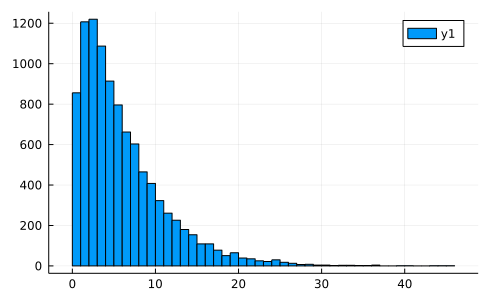

In [130]:
import Distributions
sampler_r = sampler(r, Distributions.Gamma)
plt = histogram(rand(sampler_r, 10000), nbins=50)
savefig("gamma_sampler.png")
plt

![](gamma_sampler.png)

The second parameter that we'll add to this is *nominal* (finite) and, by
default, will be sampled uniformly. Since it is nominal, we specify
`values` instead of `upper` and `lower` bounds:

In [131]:
s  = range(model, :(continuous_encoder.one_hot_ordered_factors),
           values = [true, false])

NominalRange(continuous_encoder.one_hot_ordered_factors = true, false)

#### The tuning wrapper

Now for the wrapper, which is an instance of `TunedModel`:

In [132]:
tuned_model = TunedModel(model=model,
                         ranges=[r, s],
                         resampling=CV(nfolds=6),
                         measures=cross_entropy,
                         tuning=tuning,
                         n=15)

ProbabilisticTunedModel(
    model = Pipeline330(
            standardizer = Standardizer,
            continuous_encoder = ContinuousEncoder,
            logistic_classifier = LogisticClassifier),
    tuning = RandomSearch(
            bounded = Distributions.Uniform,
            positive_unbounded = Distributions.Gamma,
            other = Distributions.Normal,
            rng = MersenneTwister(123)),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = LogLoss(tol = 2.220446049250313e-16),
    weights = nothing,
    operation = nothing,
    range = MLJBase.ParamRange[NumericRange(0.0 ≤ logistic_classifier.lambda ≤ Inf; origin=6.0, unit=5.0) on log10 scale, NominalRange(continuous_encoder.one_hot_ordered_factors = true, false)],
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = 15,
    acceleration = CPU1{Nothing}(nothing),
    acceleration_resampling

We can apply the `fit!/predict` work-flow to `tuned_model` just as
for any other model:

In [133]:
tuned_mach = machine(tuned_model, X, y);
fit!(tuned_mach);
predict(tuned_mach, rows=1:3)

┌ Info: Training Machine{ProbabilisticTunedModel{RandomSearch,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 15 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 15 metamodels: 100%[=========================] Time: 0:00:03


3-element MLJBase.UnivariateFiniteVector{Multiclass{3}, Int64, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(1=>0.631, 2=>0.22, 3=>0.149)
 UnivariateFinite{Multiclass{3}}(1=>0.844, 2=>0.00889, 3=>0.147)
 UnivariateFinite{Multiclass{3}}(1=>0.967, 2=>0.0128, 3=>0.0199)

The outcomes of the tuning can be inspected from a detailed
report. For example, we have:

In [134]:
rep = report(tuned_mach);
rep.best_model

Pipeline330(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = true),
    logistic_classifier = LogisticClassifier(
            lambda = 5.100906526305173,
            gamma = 0.0,
            penalty = :l2,
            fit_intercept = true,
            penalize_intercept = false,
            solver = nothing))

By default, sampling of a bounded range is uniform. Lets

In the special case of two-parameters, you can also plot the results:

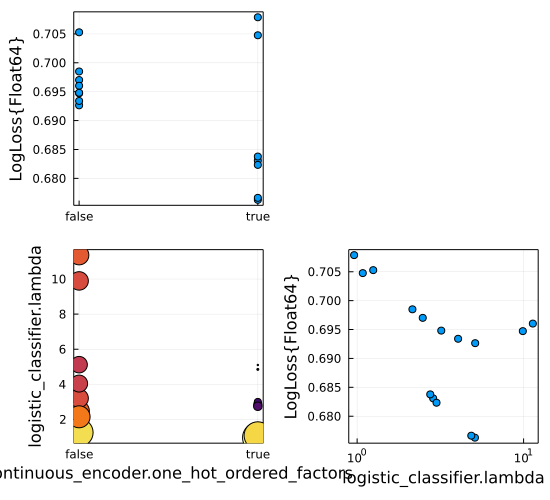

In [135]:
plt = plot(tuned_mach)
savefig("tuning.png")
plt

Finally, let's compare cross-validation estimate of the performance
of the self-tuning model with that of the original model (an example
of [*nested
resampling*]((https://mlr.mlr-org.com/articles/tutorial/nested_resampling.html)
here):

In [136]:
err = evaluate!(mach, resampling=CV(nfolds=3), measure=cross_entropy)

Evaluating over 3 folds: 100%[=========================] Time: 0:00:00


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────
│ measure                    │ measurement │ operation │ per_fold              ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.736       │ predict   │ [0.759, 0.707, 0.741] ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────


In [137]:
tuned_err = evaluate!(tuned_mach, resampling=CV(nfolds=3), measure=cross_entropy)

Evaluating over 3 folds: 100%[=========================] Time: 0:00:04


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────
│ measure                    │ measurement │ operation │ per_fold              ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.705       │ predict   │ [0.717, 0.701, 0.697] ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────


<a id='resources-for-part-4'></a>

### Resources for Part 4

- From the MLJ manual:
   - [Learning Curves](https://alan-turing-institute.github.io/MLJ.jl/dev/learning_curves/)
   - [Tuning Models](https://alan-turing-institute.github.io/MLJ.jl/dev/tuning_models/)
- The [MLJTuning repo](https://github.com/juliaai/MLJTuning.jl#who-is-this-repo-for) - mostly for developers

- From Data Science Tutorials:
    - [Tuning a model](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/model-tuning/)
    - [Crabs with XGBoost](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/crabs-xgb/) `Grid` tuning in stages for a tree-boosting model with many parameters
    - [Boston with LightGBM](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/boston-lgbm/) -  `Grid` tuning for another popular tree-booster
    - [Boston with Flux](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/boston-flux/) - optimizing batch size in a simple neural network regressor
- [UCI Horse Colic Data Set](http://archive.ics.uci.edu/ml/datasets/Horse+Colic)

### Exercises for Part 4

#### Exercise 8

This exercise continues our analysis of the King County House price
prediction problem:

In [138]:
y, X = unpack(house, ==(:price), name -> true, rng=123);

Your task will be to tune the following pipeline regression model,
which includes a gradient tree boosting component:

In [139]:
EvoTreeRegressor = @load EvoTreeRegressor
tree_booster = EvoTreeRegressor(nrounds = 70)
model = @pipeline ContinuousEncoder tree_booster

import EvoTrees ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


Pipeline345(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    evo_tree_regressor = EvoTreeRegressor(
            loss = EvoTrees.Linear(),
            nrounds = 70,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 5,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mse,
            rng = MersenneTwister(123),
            device = "cpu"))

(a) Construct a bounded range `r1` for the `evo_tree_booster`
parameter `max_depth`, varying between 1 and 12.

\star&(b) For the `nbins` parameter of the `EvoTreeRegressor`, define the range

In [140]:
r2 = range(model,
           :(evo_tree_regressor.nbins),
           lower = 2.5,
           upper= 7.5, scale=x->2^round(Int, x))

transformed NumericRange(2.5 ≤ evo_tree_regressor.nbins ≤ 7.5; origin=5.0, unit=2.5)

Notice that in this case we've specified a *function* instead of a
canned scale, like `:log10`. In this case the `scale` function is
applied after sampling (uniformly) between the limits of `lower` and
`upper`. Perhaps you can guess the outputs of the following lines of
code?

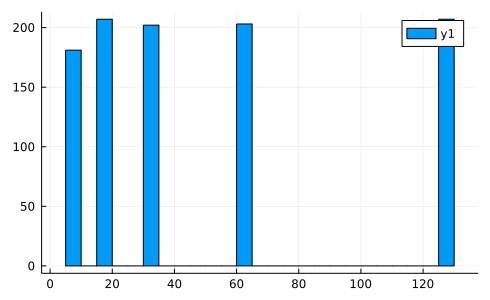

In [141]:
r2_sampler = sampler(r2, Distributions.Uniform)
samples = rand(r2_sampler, 1000);
plt = histogram(samples, nbins=50)
savefig("uniform_sampler.png")

plt

![](uniform_sampler.png)

In [142]:
sort(unique(samples))

5-element Vector{Int64}:
   8
  16
  32
  64
 128

(c) Optimize `model` over these the parameter ranges `r1` and `r2`
using a random search with uniform priors (the default). Use
`Holdout()` resampling, and implement your search by first
constructing a "self-tuning" wrap of `model`, as described
above. Make `mae` (mean absolute error) the loss function that you
optimize, and search over a total of 40 combinations of
hyper-parameters.  If you have time, plot the results of your
search. Feel free to use all available data.

(d) Evaluate the best model found in the search using 3-fold
cross-validation and compare with that of the self-tuning model
(which is different!). Setting data hygiene concerns aside, feel
free to use all available data.

<a id='part-5-advanced-model-composition'>

## Part 5 - Advanced Model Composition

> **Goals:**
> 1. Learn how to build a prototypes of a composite model, called a *learning network*
> 2. Learn how to use the `@from_network` macro to export a learning network as a new stand-alone model type

While `@pipeline` is great for composing models in an unbranching
sequence, for more complicated model composition you'll want to use
MLJ's generic model composition syntax. There are two main steps:

- **Prototype** the composite model by building a *learning
  network*, which can be tested on some (dummy) data as you build
  it.

- **Export** the learning network as a new stand-alone model type.

Like pipeline models, instances of the exported model type behave
like any other model (and are not bound to any data, until you wrap
them in a machine).

### Building a pipeline using the generic composition syntax

To warm up, we'll do the equivalent of

In [143]:
pipe = @pipeline Standardizer LogisticClassifier;

using the generic syntax.

Here's some dummy data we'll be using to test our learning network:

In [144]:
X, y = make_blobs(5, 3)
pretty(X)

┌────────────┬────────────┬────────────┐
│ x1         │ x2         │ x3         │
│ Float64    │ Float64    │ Float64    │
│ Continuous │ Continuous │ Continuous │
├────────────┼────────────┼────────────┤
│ -8.66643   │ -1.30544   │ -9.4571    │
│ -7.35199   │ -1.80323   │ -9.48707   │
│ -4.78595   │ 2.98411    │ -0.815858  │
│ -8.57023   │ -3.18263   │ -9.14575   │
│ -8.57043   │ -1.87734   │ -9.86286   │
└────────────┴────────────┴────────────┘


**Step 0** - Proceed as if you were combining the models "by hand",
using all the data available for training, transforming and
prediction:

In [145]:
stand = Standardizer();
linear = LogisticClassifier();

mach1 = machine(stand, X);
fit!(mach1);
Xstand = transform(mach1, X);

mach2 = machine(linear, Xstand, y);
fit!(mach2);
yhat = predict(mach2, Xstand)

┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


5-element MLJBase.UnivariateFiniteVector{Multiclass{3}, Int64, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(1=>0.0831, 2=>0.245, 3=>0.672)
 UnivariateFinite{Multiclass{3}}(1=>0.101, 2=>0.172, 3=>0.726)
 UnivariateFinite{Multiclass{3}}(1=>0.832, 2=>0.0589, 3=>0.109)
 UnivariateFinite{Multiclass{3}}(1=>0.0506, 2=>0.172, 3=>0.778)
 UnivariateFinite{Multiclass{3}}(1=>0.0676, 2=>0.218, 3=>0.715)

**Step 1** - Edit your code as follows:

- pre-wrap the data in `Source` nodes

- delete the `fit!` calls

In [146]:
X = source(X)  # or X = source() if not testing
y = source(y)  # or y = source()

stand = Standardizer();
linear = LogisticClassifier();

mach1 = machine(stand, X);
Xstand = transform(mach1, X);

mach2 = machine(linear, Xstand, y);
yhat = predict(mach2, Xstand)

Node{Machine{LogisticClassifier,…}}
  args:
    1:	Node{Machine{Standardizer,…}}
  formula:
    predict(
        Machine{LogisticClassifier,…}, 
        transform(
            Machine{Standardizer,…}, 
            Source @439))

Now `X`, `y`, `Xstand` and `yhat` are *nodes* ("variables" or
"dynammic data") instead of data. All training, predicting and
transforming is now executed lazily, whenever we `fit!` one of these
nodes. We *call* a node to retrieve the data it represents in the
original manual workflow.

In [147]:
fit!(Xstand)
Xstand() |> pretty

┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


┌────────────┬────────────┬────────────┐
│ x1         │ x2         │ x3         │
│ Float64    │ Float64    │ Float64    │
│ Continuous │ Continuous │ Continuous │
├────────────┼────────────┼────────────┤
│ -0.649707  │ -0.114144  │ -0.438255  │
│ 0.142925   │ -0.325739  │ -0.445966  │
│ 1.6903     │ 1.7092     │ 1.78502    │
│ -0.591698  │ -0.912075  │ -0.35815   │
│ -0.591816  │ -0.357242  │ -0.542651  │
└────────────┴────────────┴────────────┘


In [148]:
fit!(yhat);
yhat()

┌ Info: Not retraining Machine{Standardizer,…}. Use `force=true` to force.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:406
┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


5-element MLJBase.UnivariateFiniteVector{Multiclass{3}, Int64, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(1=>0.0831, 2=>0.245, 3=>0.672)
 UnivariateFinite{Multiclass{3}}(1=>0.101, 2=>0.172, 3=>0.726)
 UnivariateFinite{Multiclass{3}}(1=>0.832, 2=>0.0589, 3=>0.109)
 UnivariateFinite{Multiclass{3}}(1=>0.0506, 2=>0.172, 3=>0.778)
 UnivariateFinite{Multiclass{3}}(1=>0.0676, 2=>0.218, 3=>0.715)

The node `yhat` is the "descendant" (in an associated DAG we have
defined) of a unique source node:

In [149]:
sources(yhat)

2-element Vector{Any}:
 Source @439 ⏎ `Table{AbstractVector{Continuous}}`
 Source @857 ⏎ `AbstractVector{Multiclass{3}}`

The data at the source node is replaced by `Xnew` to obtain a
new prediction when we call `yhat` like this:

In [150]:
Xnew, _ = make_blobs(2, 3);
yhat(Xnew)

2-element MLJBase.UnivariateFiniteVector{Multiclass{3}, Int64, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(1=>0.000335, 2=>0.000995, 3=>0.999)
 UnivariateFinite{Multiclass{3}}(1=>0.0928, 2=>0.00217, 3=>0.905)

**Step 2** - Export the learning network as a new stand-alone model type

Now, somewhat paradoxically, we can wrap the whole network in a
special machine - called a *learning network machine* - before have
defined the new model type. Indeed doing so is a necessary step in
the export process, for this machine will tell the export macro:

- what kind of model the composite will be (`Deterministic`,
  `Probabilistic` or `Unsupervised`)a

- which source nodes are input nodes and which are for the target

- which nodes correspond to each operation (`predict`, `transform`,
  etc) that we might want to define

In [151]:
surrogate = Probabilistic()     # a model with no fields!
mach = machine(surrogate, X, y; predict=yhat)

Machine{ProbabilisticSurrogate,…} trained 0 times; does not cache data
  args: 
    1:	Source @439 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @857 ⏎ `AbstractVector{Multiclass{3}}`


Although we have no real need to use it, this machine behaves like
you'd expect it to:

In [152]:
Xnew, _ = make_blobs(2, 3)
fit!(mach)
predict(mach, Xnew)

┌ Info: Not retraining Machine{Standardizer,…}. Use `force=true` to force.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:406
┌ Info: Not retraining Machine{LogisticClassifier,…}. Use `force=true` to force.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:406


2-element MLJBase.UnivariateFiniteVector{Multiclass{3}, Int64, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(1=>0.108, 2=>0.135, 3=>0.757)
 UnivariateFinite{Multiclass{3}}(1=>0.324, 2=>0.0784, 3=>0.597)

Now we create a new model type using a Julia `struct` definition
appropriately decorated:

In [153]:
@from_network mach begin
    mutable struct YourPipe
        standardizer = stand
        classifier = linear::Probabilistic
    end
end

Instantiating and evaluating on some new data:

In [154]:
pipe = YourPipe()
X, y = @load_iris;   # built-in data set
mach = machine(pipe, X, y)
evaluate!(mach, measure=misclassification_rate, operation=predict_mode)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:02


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────────┬─────────────┬──────────────┬────────────────────────
│ measure                 │ measurement │ operation    │ per_fold              ⋯
├─────────────────────────┼─────────────┼──────────────┼────────────────────────
│ MisclassificationRate() │ 0.08        │ predict_mode │ [0.0, 0.04, 0.08, 0.0 ⋯
└─────────────────────────┴─────────────┴──────────────┴────────────────────────
                                                                1 column omitted


### A composite model to average two regressor predictors

The following is condensed version of
[this](https://github.com/alan-turing-institute/MLJ.jl/blob/master/binder/MLJ_demo.ipynb)
tutorial. We will define a composite model that:

- standardizes the input data

- learns and applies a Box-Cox transformation to the target variable

- blends the predictions of two supervised learning models - a ridge
 regressor and a random forest regressor; we'll blend using a simple
 average (for a more sophisticated stacking example, see
 [here](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/stacking/))

- applies the *inverse* Box-Cox transformation to this blended prediction

In [155]:
RandomForestRegressor = @load RandomForestRegressor pkg=DecisionTree

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


MLJDecisionTreeInterface.RandomForestRegressor

**Input layer**

In [156]:
X = source()
y = source()

Source @471 ⏎ `Nothing`

**First layer and target transformation**

In [157]:
std_model = Standardizer()
stand = machine(std_model, X)
W = MLJ.transform(stand, X)

box_model = UnivariateBoxCoxTransformer()
box = machine(box_model, y)
z = MLJ.transform(box, y)

Node{Machine{UnivariateBoxCoxTransformer,…}}
  args:
    1:	Source @471
  formula:
    transform(
        Machine{UnivariateBoxCoxTransformer,…}, 
        Source @471)

**Second layer**

In [158]:
ridge_model = RidgeRegressor(lambda=0.1)
ridge = machine(ridge_model, W, z)

forest_model = RandomForestRegressor(n_trees=50)
forest = machine(forest_model, W, z)

ẑ = 0.5*predict(ridge, W) + 0.5*predict(forest, W)

Node{Nothing}
  args:
    1:	Node{Nothing}
    2:	Node{Nothing}
  formula:
    +(
        #134(
            predict(
                Machine{RidgeRegressor,…}, 
                transform(
                    Machine{Standardizer,…}, 
                    Source @346))),
        #134(
            predict(
                Machine{RandomForestRegressor,…}, 
                transform(
                    Machine{Standardizer,…}, 
                    Source @346))))

**Output**

In [159]:
ŷ = inverse_transform(box, ẑ)

Node{Machine{UnivariateBoxCoxTransformer,…}}
  args:
    1:	Node{Nothing}
  formula:
    inverse_transform(
        Machine{UnivariateBoxCoxTransformer,…}, 
        +(
            #134(
                predict(
                    Machine{RidgeRegressor,…}, 
                    transform(
                        Machine{Standardizer,…}, 
                        Source @346))),
            #134(
                predict(
                    Machine{RandomForestRegressor,…}, 
                    transform(
                        Machine{Standardizer,…}, 
                        Source @346)))))

With the learning network defined, we're ready to export:

In [160]:
@from_network machine(Deterministic(), X, y, predict=ŷ) begin
    mutable struct CompositeModel
        rgs1 = ridge_model
        rgs2 = forest_model
    end
end

Let's instantiate the new model type and try it out on some data:

In [161]:
composite = CompositeModel()

CompositeModel(
    rgs1 = RidgeRegressor(
            lambda = 0.1,
            fit_intercept = true,
            penalize_intercept = false,
            solver = nothing),
    rgs2 = RandomForestRegressor(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 50,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0,
            rng = Random._GLOBAL_RNG()))

In [162]:
X, y = @load_boston;
mach = machine(composite, X, y);
evaluate!(mach,
          resampling=CV(nfolds=6, shuffle=true),
          measures=[rms, mae])

Evaluating over 6 folds: 100%[=========================] Time: 0:00:06


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────┬─────────────┬───────────┬────────────────────────────
│ measure                │ measurement │ operation │ per_fold                  ⋯
├────────────────────────┼─────────────┼───────────┼────────────────────────────
│ RootMeanSquaredError() │ 3.89        │ predict   │ [3.89, 3.93, 2.79, 2.81,  ⋯
│ MeanAbsoluteError()    │ 2.46        │ predict   │ [2.59, 2.44, 2.1, 2.16, 2 ⋯
└────────────────────────┴─────────────┴───────────┴────────────────────────────
                                                                1 column omitted


### Resources for Part 5

- From the MLJ manual:
   - [Learning Networks](https://alan-turing-institute.github.io/MLJ.jl/stable/composing_models/#Learning-Networks-1)
- From Data Science Tutorials:
    - [Learning Networks](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/learning-networks/)
    - [Learning Networks 2](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/learning-networks-2/)

    - [Stacking](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/stacking/): an advanced example of model composition

    - [Finer Control](https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/#Method-II:-Finer-control-(advanced)-1):
      exporting learning networks without a macro for finer control

<a id='solutions-to-exercises'></a>

## Solutions to exercises

#### Exercise 2 solution

In [163]:
quality = coerce(quality, OrderedFactor);
levels!(quality, ["poor", "good", "excellent"]);
elscitype(quality)

┌ Info: Trying to coerce from `Union{Missing, String}` to `OrderedFactor`.
│ Coerced to `Union{Missing,OrderedFactor}` instead.
└ @ ScientificTypes /Users/anthony/.julia/packages/ScientificTypes/z5Vmr/src/convention/coerce.jl:174


Union{Missing, OrderedFactor{3}}

#### Exercise 3 solution

First pass:

In [164]:
coerce!(house, autotype(house));
schema(house)

┌───────────────┬───────────────────────────────────┬───────────────────┐
│ _.names       │ _.types                           │ _.scitypes        │
├───────────────┼───────────────────────────────────┼───────────────────┤
│ price         │ Float64                           │ Continuous        │
│ bedrooms      │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{13} │
│ bathrooms     │ CategoricalValue{Float64, UInt32} │ OrderedFactor{30} │
│ sqft_living   │ Float64                           │ Continuous        │
│ sqft_lot      │ Float64                           │ Continuous        │
│ floors        │ CategoricalValue{Float64, UInt32} │ OrderedFactor{6}  │
│ waterfront    │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{2}  │
│ view          │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{5}  │
│ condition     │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{5}  │
│ grade         │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{12} │
│ sqft_above    │ Float64             

All the "sqft" fields refer to "square feet" so are
really `Continuous`. We'll regard `:yr_built` (the other `Count`
variable above) as `Continuous` as well. So:

In [165]:
coerce!(house, Count => Continuous);

And `:zipcode` should not be ordered:

In [166]:
coerce!(house, :zipcode => Multiclass);
schema(house)

┌───────────────┬───────────────────────────────────┬───────────────────┐
│ _.names       │ _.types                           │ _.scitypes        │
├───────────────┼───────────────────────────────────┼───────────────────┤
│ price         │ Float64                           │ Continuous        │
│ bedrooms      │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{13} │
│ bathrooms     │ CategoricalValue{Float64, UInt32} │ OrderedFactor{30} │
│ sqft_living   │ Float64                           │ Continuous        │
│ sqft_lot      │ Float64                           │ Continuous        │
│ floors        │ CategoricalValue{Float64, UInt32} │ OrderedFactor{6}  │
│ waterfront    │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{2}  │
│ view          │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{5}  │
│ condition     │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{5}  │
│ grade         │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{12} │
│ sqft_above    │ Float64             

`:bathrooms` looks like it has a lot of levels, but on further
inspection we see why, and `OrderedFactor` remains appropriate:

In [167]:
import StatsBase.countmap
countmap(house.bathrooms)

Dict{CategoricalValue{Float64, UInt32}, Int64} with 30 entries:
  5.0  => 21
  5.25 => 13
  1.25 => 9
  8.0  => 2
  6.75 => 2
  1.0  => 3852
  5.5  => 10
  0.0  => 10
  6.0  => 6
  6.25 => 2
  4.75 => 23
  3.25 => 589
  3.0  => 753
  2.25 => 2047
  0.5  => 4
  7.5  => 1
  5.75 => 4
  1.5  => 1446
  3.75 => 155
  4.0  => 136
  4.25 => 79
  2.0  => 1930
  2.75 => 1185
  3.5  => 731
  6.5  => 2
  ⋮    => ⋮

#### Exercise 4 solution

4(a)

There are *no* models that apply immediately:

In [168]:
models(matching(X4, y4))

NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple[]

4(b)

In [169]:
y4 = coerce(y4, Continuous);
models(matching(X4, y4))

6-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = ConstantRegressor, package_name = MLJModels, ... )
 (name = DecisionTreeRegressor, package_name = BetaML, ... )
 (name = DecisionTreeRegressor, package_name = DecisionTree, ... )
 (name = DeterministicConstantRegressor, package_name = MLJModels, ... )
 (name = RandomForestRegressor, package_name = BetaML, ... )
 (name = RandomForestRegressor, package_name = DecisionTree, ... )

#### Exercise 6 solution

6(a)

In [170]:
y, X = unpack(horse,
              ==(:outcome),
              name -> elscitype(Tables.getcolumn(horse, name)) == Continuous);

6(b)(i)

In [171]:
model = (@load LogisticClassifier pkg=MLJLinearModels)();
model.lambda = 100
mach = machine(model, X, y)
fit!(mach, rows=train)
fitted_params(mach)

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168
┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


(classes = CategoricalValue{Int64, UInt32}[1, 2, 3],
 coefs = Pair{Symbol, SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}[:rectal_temperature => [0.061700165029243595, -0.06507181612449195, 0.003371651095248075], :pulse => [-0.009584825604133507, 0.004022558654903623, 0.005562266949230421], :respiratory_rate => [-0.009584825604133507, 0.004022558654903623, 0.005562266949230421], :packed_cell_volume => [-0.04309372172868995, 0.020859863946466082, 0.022233857782222862], :total_protein => [0.02750875240430624, -0.06317268051316188, 0.03566392810885553]],
 intercept = [0.0008917385182322375, -0.000891738518934035, -4.972412447643922],)

In [172]:
coefs_given_feature = Dict(fitted_params(mach).coefs)
coefs_given_feature[:pulse]

#6(b)(ii)

yhat = predict(mach, rows=test); # or predict(mach, X[test,:])
err = cross_entropy(yhat, y[test]) |> mean

0.7187276476001894

6(b)(iii)

The predicted probabilities of the actual observations in the test
are given by

In [173]:
p = broadcast(pdf, yhat, y[test]);

The number of times this probability exceeds 50% is:

In [174]:
n50 = filter(x -> x > 0.5, p) |> length

30

Or, as a proportion:

In [175]:
n50/length(test)

0.6666666666666666

6(b)(iv)

In [176]:
misclassification_rate(mode.(yhat), y[test])

0.28888888888888886

6(c)(i)

In [177]:
model = (@load RandomForestClassifier pkg=DecisionTree)()
mach = machine(model, X, y)
evaluate!(mach, resampling=CV(nfolds=6), measure=cross_entropy)

r = range(model, :n_trees, lower=10, upper=70, scale=:log10)

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168
Evaluating over 6 folds: 100%[=========================] Time: 0:00:01


NumericRange(10 ≤ n_trees ≤ 70; origin=40.0, unit=30.0) on log10 scale

Since random forests are inherently randomized, we generate multiple
curves:

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 29 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 29 metamodels: 100%[=========================] Time: 0:00:01
┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 29 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 29 metamodels: 100%[=========================] Time: 0:00:00
┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 29 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 29 metamodels: 100%[===============

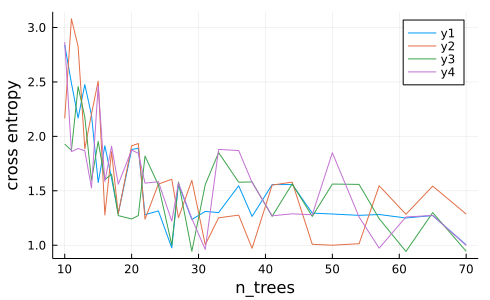

In [178]:
plt = plot()
for i in 1:4
    one_curve = learning_curve(mach,
                           range=r,
                           resampling=Holdout(),
                           measure=cross_entropy)
    plot!(one_curve.parameter_values, one_curve.measurements)
end
xlabel!(plt, "n_trees")
ylabel!(plt, "cross entropy")
savefig("exercise_6ci.png")
plt

6(c)(ii)

In [179]:
evaluate!(mach, resampling=CV(nfolds=9),
                measure=cross_entropy,
                rows=train).measurement[1]

model.n_trees = 90

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/resampling.jl:495
Evaluating over 9 folds: 100%[=========================] Time: 0:00:00


90

6(c)(iii)

In [180]:
err_forest = evaluate!(mach, resampling=Holdout(),
                       measure=cross_entropy).measurement[1]

0.6868562419362649

#### Exercise 7

(a)

In [181]:
KMeans = @load KMeans pkg=Clustering
EvoTreeClassifier = @load EvoTreeClassifier
pipe = @pipeline(Standardizer,
                 ContinuousEncoder,
                 KMeans(k=10),
                 EvoTreeClassifier(nrounds=50))

import MLJClusteringInterface ✔
import EvoTrees ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


Pipeline371(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    k_means = KMeans(
            k = 10,
            metric = Distances.SqEuclidean(0.0)),
    evo_tree_classifier = EvoTreeClassifier(
            loss = EvoTrees.Softmax(),
            nrounds = 50,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 5,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mlogloss,
            rng = MersenneTwister(123),
            device = "cpu"))

(b)

In [182]:
mach = machine(pipe, X, y)
evaluate!(mach, resampling=CV(nfolds=6), measure=cross_entropy)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:28


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────
│ measure                    │ measurement │ operation │ per_fold              ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.783       │ predict   │ [0.757, 0.862, 0.76,  ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────
                                                                1 column omitted


(c)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:13


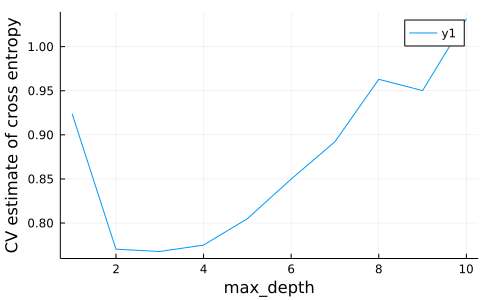

In [183]:
r = range(pipe, :(evo_tree_classifier.max_depth), lower=1, upper=10)

curve = learning_curve(mach,
                       range=r,
                       resampling=CV(nfolds=6),
                       measure=cross_entropy)

plt = plot(curve.parameter_values, curve.measurements)
xlabel!(plt, "max_depth")
ylabel!(plt, "CV estimate of cross entropy")
savefig("exercise_7c.png")
plt

Here's a second curve using a different random seed for the booster:

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:13


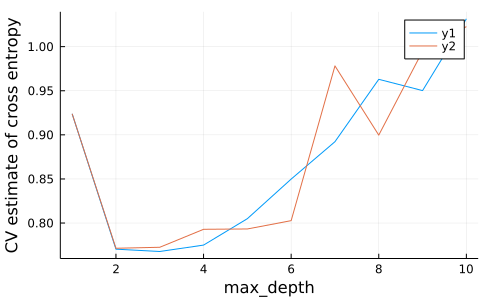

In [184]:
using Random
pipe.evo_tree_classifier.rng = MersenneTwister(123)
curve = learning_curve(mach,
                       range=r,
                       resampling=CV(nfolds=6),
                       measure=cross_entropy)
plot!(curve.parameter_values, curve.measurements)
savefig("exercise_7c_2.png")
plt

One can automatic the production of multiple curves with different
seeds in the following way:

Evaluating Learning curve with 6 rngs: 100%[==================] Time: 0:01:30


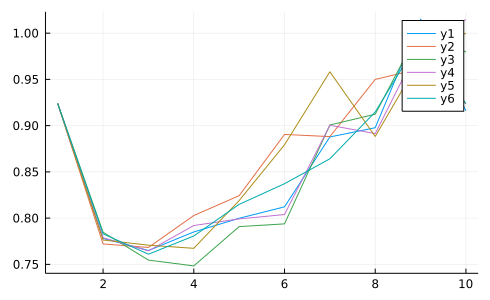

In [185]:
curves = learning_curve(mach,
                        range=r,
                        resampling=CV(nfolds=6),
                        measure=cross_entropy,
                        rng_name=:(evo_tree_classifier.rng),
                        rngs=6) # list of RNGs, or num to auto generate
plt = plot(curves.parameter_values, curves.measurements)
savefig("exercise_7c_3.png")
plt

If you have multiple threads available in your julia session, you
can add the option `acceleration=CPUThreads()` to speed up this
computation.

#### Exercise 8

In [186]:
y, X = unpack(house, ==(:price), name -> true, rng=123);

EvoTreeRegressor = @load EvoTreeRegressor
tree_booster = EvoTreeRegressor(nrounds = 70)
model = @pipeline ContinuousEncoder tree_booster

import EvoTrees ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


Pipeline401(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    evo_tree_regressor = EvoTreeRegressor(
            loss = EvoTrees.Linear(),
            nrounds = 70,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 5,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mse,
            rng = MersenneTwister(123),
            device = "cpu"))

(a)

In [187]:
r1 = range(model, :(evo_tree_regressor.max_depth), lower=1, upper=12)

NumericRange(1 ≤ evo_tree_regressor.max_depth ≤ 12; origin=6.5, unit=5.5)

(c)

┌ Info: Training Machine{DeterministicTunedModel{RandomSearch,…},…}.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 40 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 40 metamodels: 100%[=========================] Time: 0:03:31


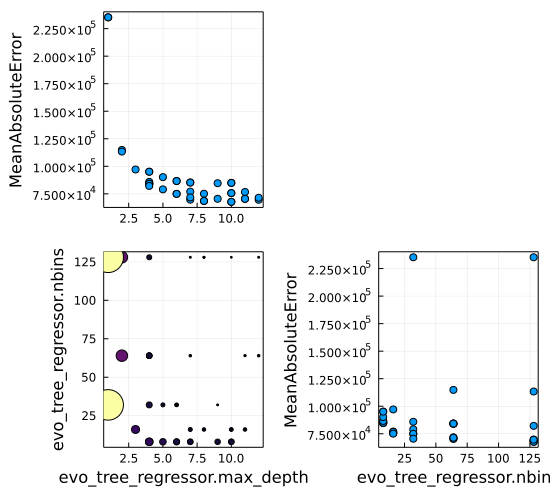

In [188]:
tuned_model = TunedModel(model=model,
                         ranges=[r1, r2],
                         resampling=Holdout(),
                         measures=mae,
                         tuning=RandomSearch(rng=123),
                         n=40)

tuned_mach = machine(tuned_model, X, y) |> fit!
plt = plot(tuned_mach)
savefig("exercise_8c.png")
plt

(d)

In [189]:
best_model = report(tuned_mach).best_model;
best_mach = machine(best_model, X, y);
best_err = evaluate!(best_mach, resampling=CV(nfolds=3), measure=mae)

Evaluating over 3 folds: 100%[=========================] Time: 0:00:50


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────┬─────────────┬───────────┬─────────────────────────────┐
│ measure             │ measurement │ operation │ per_fold                    │
├─────────────────────┼─────────────┼───────────┼─────────────────────────────┤
│ MeanAbsoluteError() │ 68700.0     │ predict   │ [68800.0, 67800.0, 69500.0] │
└─────────────────────┴─────────────┴───────────┴─────────────────────────────┘


In [190]:
tuned_err = evaluate!(tuned_mach, resampling=CV(nfolds=3), measure=mae)

Evaluating over 3 folds: 100%[=========================] Time: 0:07:17


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────┬─────────────┬───────────┬─────────────────────────────┐
│ measure             │ measurement │ operation │ per_fold                    │
├─────────────────────┼─────────────┼───────────┼─────────────────────────────┤
│ MeanAbsoluteError() │ 69900.0     │ predict   │ [71400.0, 67800.0, 70500.0] │
└─────────────────────┴─────────────┴───────────┴─────────────────────────────┘


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*